In [1]:
import numpy as np
import pandas as pd
import pickle as pkl 
import xarray as xr
import copy
import os
import sys 
import metrics
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import kstest
import pylab 
import scipy.stats as stats
from numpy.linalg import LinAlgError
from IPython.display import clear_output
print("XArray version: ", xr.__version__)
colz = ['#1f77b4', '#ff7f0e', '#2ca02c', '#bdbdbd']

XArray version:  0.16.1


In [2]:
##########################################################################################################
# LOAD IN THE DATA
##########################################################################################################
with open('./model_output_for_analysis/nwm_chrt_v2_1d_local.p', 'rb') as fb: 
    nwm_results = pkl.load(fb)

lstm_results_time_split1={}
mclstm_results_time_split1={}
sacsma_results_time_split1={}
lstm_results_time_split2={}
mclstm_results_time_split2={}
sacsma_results_time_split2={}

for forcing_type in ['nldas', 'daymet']:
    
    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split1[forcing_type] = pkl.load(fb)

    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        lstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/mclstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        mclstm_results_time_split2[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/sacsma_time_split2_{}.p'.format(forcing_type), 'rb') as fb: 
        sacsma_results_time_split2[forcing_type] = pkl.load(fb)

train_split_type_model_set = {'time_split1':{'nwm':nwm_results, 
                                           'lstm':lstm_results_time_split1,
                                            'mc':mclstm_results_time_split1,
                                            'sac':sacsma_results_time_split1},
                              'time_split2':{'nwm':nwm_results,
                                           'lstm':lstm_results_time_split2,
                                            'mc':mclstm_results_time_split2,
                                            'sac':sacsma_results_time_split2}}

In [3]:
##########################################################################################################
# USE A CONVERSION BETWEEN MODELS AND DATA
##########################################################################################################
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [4]:
##########################################################################################################
# Get all the CAMELS attributes.  
##########################################################################################################

# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [5]:
# Get the hydrologic units for each basin.
with open('../data/usgs_site_info.csv', 'r') as f:
    usgs_sites = pd.read_csv(f, skiprows=24, index_col='site_no')
usgs_idx_int = []
for idx in usgs_sites.index.values:
    usgs_idx_int.append(int(idx))
usgs_sites.reindex(usgs_idx_int)
usgs_sites = usgs_sites.reindex(usgs_idx_int)
basin_hydro_unit = []
for b in pd_attributes.basin_id_str.values:
    huc_cd = usgs_sites.loc[int(b),'huc_cd']
    hu = '{:08d}'.format(huc_cd)
    basin_hydro_unit.append(hu[0:2])
pd_attributes['basin_hydro_unit'] = basin_hydro_unit
huc_regions = set(list(pd_attributes['basin_hydro_unit']))

In [6]:
pd_attributes

,q_mean,runoff_ratio,slope_fdc,baseflow_index,stream_elas,q5,q95,high_q_freq,high_q_dur,low_q_freq,...,dom_land_cover_frac,dom_land_cover,root_depth_50,root_depth_99,ri_5,ri_10,ri_50,ri_500,basin_id_str,basin_hydro_unit
gauge_id,,,,,,,,,,,,,,,,,,,,,
1466500,0.853262,0.241046,0.969017,0.837327,0.225542,0.395636,1.637114,0.20,2.000000,0.00,...,1.000000,1,0.250000,2.40000,19,23,43,82,01466500,02
10244950,0.456547,0.345790,0.806192,0.834000,1.466961,0.182192,1.214612,2.00,20.000000,0.00,...,1.000000,5,0.120000,1.50000,33,42,81,163,10244950,16
10172800,1.368262,0.703951,1.174732,0.723371,1.489173,0.375716,4.862210,6.70,4.785714,0.00,...,1.000000,5,0.120000,1.50000,57,82,121,202,10172800,16
9378630,0.210643,0.133275,0.168888,0.497448,4.293214,0.000000,1.338338,87.10,35.551020,277.15,...,0.760344,4,0.165621,1.50000,32,75,163,401,09378630,14
13018300,1.000693,0.448945,0.955965,0.688058,1.406788,0.245534,3.683017,9.40,9.894737,7.35,...,0.563766,11,0.148188,1.66913,112,153,202,292,13018300,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14139800,6.803137,0.857853,1.927851,0.541765,0.932655,0.661237,21.207662,4.55,1.784314,83.00,...,1.000000,11,0.170000,1.80000,2437,3453,4072,5644,14139800,17
14303200,5.357591,0.800309,2.008750,0.538192,1.318645,0.364254,18.212721,10.75,2.756410,109.50,...,1.000000,11,0.170000,1.80000,403,513,753,1140,14303200,17
14306340,4.161376,0.641211,2.044051,0.478172,0.983996,0.117927,17.439948,26.90,3.659864,143.50,...,1.000000,11,0.170000,1.80000,721,986,1380,2215,14306340,17


In [7]:
huc_regions = pd_attributes.basin_hydro_unit.unique()
huc_regions.sort()

In [8]:
def get_basin_region(pd_attributes, basin_0str):
    return pd_attributes.loc[int(basin_0str), "basin_hydro_unit"]

In [9]:
get_basin_region(pd_attributes, "13018300")

'17'

In [10]:
##########################################################################################################
# Loop through all the SACSMA runs and check that the results are good. 
# Get a list of basins that has good calibration results.
##########################################################################################################
basin_list_all_camels = list(pd_attributes['basin_id_str'].values)
basin_list_sacsma_good = {ts:copy.deepcopy(basin_list_all_camels) for ts in ['time_split1', 'time_split2']}

for ib, basin_0str in enumerate(basin_list_all_camels): 
    remove_basin_id_from_list = False
    for train_split_type in ['time_split1', 'time_split2']:
        for forcing_type in ['nldas', 'daymet']:

            if basin_0str not in list(train_split_type_model_set[train_split_type]['sac'][forcing_type].columns):
                remove_basin_id_from_list = True
            elif train_split_type_model_set[train_split_type]['sac'][forcing_type][basin_0str].sum() <=0:
                remove_basin_id_from_list = True

            if train_split_type == 'time_split2' and forcing_type == 'nldas':
                if basin_0str not in list(train_split_type_model_set[train_split_type]['nwm'].keys()):
                    remove_basin_id_from_list = True

    if remove_basin_id_from_list:
        basin_list_sacsma_good[train_split_type].remove(basin_0str)

In [11]:
##########################################################################################################
#-------------------------------------------------------------------------------------------------
# Solve this problem. I think it is the xarray structures...
# isibleDeprecationWarning: Creating an ndarray from ragged nested sequences 
# (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. 
# If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
##########################################################################################################
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [12]:
##########################################################################################################
# REVERT TO THESE AS THE FLOWS
##########################################################################################################
flows = ['lstm', 'mc', 'sac', 'obs']


In [13]:
def get_specifications(tsplt, forcing_type):
    """
    This function is designed to return specific details of the simulation period
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    Returns
        start_date (pd.Timestamp): The date the simulation period started
        end_date (pd.Timestamp): The date the simulation period ended
        labelz (dictionary): A mapping between short model name and long model name
        models (list): the short model names
        flows (list): the short model names plus "obs" for observed flow
        basin_list (list): the list of basins that meet the criteria for analysis
        tsplit (str): Either time_split2 or time_split1
        forcing_type (str): Either nldas or daymet
    """
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'nwm':'NWM*', 'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['nwm', 'lstm', 'mc', 'sac']
        flows = ['nwm', 'lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    elif tsplt == 'time_split2':
        start_date = pd.Timestamp('1996-10-01')
        end_date = pd.Timestamp('2014-01-01')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
    else:
        start_date = pd.Timestamp('1989-10-01')
        end_date = pd.Timestamp('1999-09-30')
        labelz={'lstm':'LSTM', 'mc':'MC-LSTM','sac':'SAC-SMA', 'obs':'Observed'}
        models = ['lstm', 'mc', 'sac']
        flows = ['lstm', 'mc', 'sac', 'obs']
        basin_list = list(lstm_results_time_split1[forcing_type].keys())[:-1]

    spex = {"start_date":start_date,
            "end_date":end_date,
            "labelz":labelz,
            "models":models,
            "flows":flows, 
            "basin_list":basin_list,
            "tsplt":tsplt,
            "forcing_type":forcing_type}
    return spex #(start_date, end_date, labelz, models, flows, basin_list)

In [14]:
def get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date):
    #-------------------------------------------------------------------------------------------------
    # Make dictionary with all the flows
    flow_mm = {}
    #-------------------------------------------------------------------------------------------------
    if tsplt == 'time_split2' and forcing_type == 'nldas':
        #-------------------------------------------------------------------------------------------------
        # We need the basin area to convert to CFS
        basin_area = pd_attributes.loc[int(basin_0str), 'area_geospa_fabric']\
        #-------------------------------------------------------------------------------------------------

        # Get the NWM data for this basin in an xarray dataset.
        xr_nwm = xr.DataArray(nwm_results[basin_0str]['streamflow'].values,
                 coords=[nwm_results[basin_0str]['streamflow'].index],
                 dims=['datetime'])
        # convert from CFS to mm/day
        # fm3/s * 3600 sec/hour * 24 hour/day / (m2 * mm/m)
        xrr = xr_nwm.loc[start_date:end_date]*3600*24/(basin_area*1000)
        flow_mm['nwm'] = pd.DataFrame(data=xrr.values)
    #-------------------------------------------------------------------------------------------------
    # Standard LSTM 
    if tsplt == 'time_split1':
        xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['lstm'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # Mass-conserving LSTM data trained on all years
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_sim'].loc[start_date:end_date]
        flow_mm['mc'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)
    #-------------------------------------------------------------------------------------------------
    # SACSMA Mean
    if tsplt == 'time_split1':
        df = sacsma_results_time_split1[forcing_type][basin_0str].loc[start_date:end_date]
    if tsplt == 'time_split2':
        df = sacsma_results_time_split2[forcing_type][basin_0str].loc[start_date:end_date]
    flow_mm['sac'] = df
    #-------------------------------------------------------------------------------------------------
    # OBSERVATIONS
    if tsplt == 'time_split1':
        xrr = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
    if tsplt == 'time_split2':
        xrr = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
        flow_mm['obs'] = pd.DataFrame(data=xrr.values,index=xrr.date.values)

    #-------------------------------------------------------------------------------------------------
    # Make sure we are in a time period that all the flow members have values
    # If there is missin observations than we can't compare the mass of the observed with simulaitons
    skip_basin_because_missing_obs = False
    if tsplt == 'time_split1':
        obs_temp = mclstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].datetime
    if tsplt == 'time_split2':
        obs_temp = mclstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date
        
    return flow_mm, obs_temp


In [15]:
def scatter_plot_of_rr_events_for_basin(nldas, daymet, basin_0str, spex, plot_bounds=[0,2]):
    plt.scatter(nldas.RR_obs, nldas.RR_lstm, label="NLDAS lstm", c=colz[0])
    plt.scatter(nldas.RR_obs, nldas.RR_mc, label="NLDAS mc-lstm", c=colz[1])
    plt.scatter(nldas.RR_obs, nldas.RR_sac, label="NLDAS sac-sma", c=colz[2])
    plt.scatter(daymet.RR_obs, daymet.RR_lstm, marker="x", label="Daymet lstm", c=colz[0])
    plt.scatter(daymet.RR_obs, daymet.RR_mc, marker="x", label="Daymet mc-lstm", c=colz[1])
    plt.scatter(daymet.RR_obs, daymet.RR_sac, marker="x", label="Daymet sac-sma", c=colz[2])
    plt.title(f"runoff ratio at basin {basin_0str}")
    plt.xlabel("observed")
    plt.ylabel("simulated")
    plt.xlim(plot_bounds)
    plt.ylim(plot_bounds)
    plt.legend()
    plt.show()
    plt.close()

In [16]:
forcing_products = ['nldas','daymet']
file_name_map = {'nldas':'nldas', 'daymet':'cida'}
precip_column_map = {'nldas':'PRCP(mm/day)', 'daymet':'prcp(mm/day)'}

In [17]:
def precipitation_event_thresholds(percent_threshold, forcing):
    precip_threshold = 0
    # Event definition threshold
    any_precip = forcing[forcing>0].values
    any_precip.sort()
    onethrough = np.array([i for i in range(any_precip.shape[0])])/any_precip.shape[0]
    for i in range(any_precip.shape[0]):
        if onethrough[i] > percent_threshold:
            precip_threshold = any_precip[i]
            break
    return precip_threshold

def load_forcing_and_identify_events(tsplt, basin_0str, file_name_map, forcing_type):
    """
    This function loads in the forcing, and also identifies the indices of precipitation "events"
    Events are arbitrarily defined as any time the precipitation is greater than the median (non zero) precip
    
    Inputs:
        tsplit (str): Either time_split2 or time_split1
        basin_0str (str): The basin ID as a string with a leading zero
        forcing_dir (str): The directory where to find the forcing file
        file_name_map (dictionary): 
        forcing_type (str): either nldas or daymet
        precip_threshold (float): The decimal number representing the event threshold percentage
    Return:
        forcing (pd.DataFrame): The forcing data for a particular basin
        precip_events (list): Indices of official precipitation "events"
    """
    
    forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
        f'/basin_mean_forcing/{forcing_type}_all_basins_in_one_directory/'
    
    basin_int = int(basin_0str)
    #-------------------------------------------------------------------------------------------------
    # FORCING
    forcing = pd.read_csv(f'{forcing_dir}{basin_0str}_lump_{file_name_map[forcing_type]}_forcing_leap.txt',
                          delim_whitespace=True, header=3)
    if tsplt == 'time_split1':
        forcing = forcing.iloc[3560:7214]
    if tsplt == 'time_split2':
        forcing = forcing.iloc[6118:]
    forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
    #-------------------------------------------------------------------------------------------------
    
    f_label = precip_column_map[forcing_type]
    
    
    precip_threshold_peak = precipitation_event_thresholds(0.25, forcing[f_label])
    precip_threshold_low = precipitation_event_thresholds(0.05, forcing[f_label])   
    
    # Identify events (criteria: precip days with two precip free days before and after)
    max_precip_event = 10
    event_window = 2
    precip_event_start_end_index = []
    for i in range(3, forcing[f_label].shape[0]-max_precip_event-event_window):
        if i < event_window or i > forcing[f_label].shape[0]-event_window:
            continue
        if forcing[f_label][i] > precip_threshold_peak:
            if np.sum(forcing[f_label][i-event_window:i]) < precip_threshold_low:
                for j in range(i+1,i+max_precip_event):
                    if forcing[f_label][j] == 0:
                        if np.sum(forcing[f_label][j:j+event_window]) < precip_threshold_low:
                            precip_event_start_end_index.append([i-event_window,j+event_window+1])
                        break
    print(f"Number of precipitation events {len(precip_event_start_end_index)} above threshold {precip_threshold_peak}mm and a window below {precip_threshold_low}mm")
    
    return forcing, precip_event_start_end_index

In [18]:
def calculate_mass_balance_over_events(basin_0str, spex, forcing, precip_events):
    
    basin_int = int(basin_0str)
    start_date = spex["start_date"]
    end_date = spex["end_date"]
    tsplt = spex["tsplt"]
    models = spex['models']
    flows = spex['flows']
    forcing_type = spex['forcing_type']
    
    mass_balance_over_events = pd.DataFrame(columns=["event",
                                                     "event_date",
                                                     "event_days",
                                                     "total_precip", 
                                                     "total_obs", 
                                                     "IN_obs",
                                                     "total_lstm",
                                                     "total_mc",
                                                     "total_sac",
                                                     "RR_obs",
                                                     "AME_lstm",
                                                     "PME_lstm",
                                                     "NME_lstm",
                                                     "RR_lstm",
                                                     "IN_lstm"
                                                     "AME_mc",
                                                     "PME_mc",
                                                     "NME_mc",
                                                     "RR_mc",
                                                     "IN_mc",
                                                     "AME_sac",
                                                     "PME_sac",
                                                     "NME_sac",
                                                     "RR_sac",
                                                     "IN_sac"])
    if "nwm" in models:
        mass_balance_over_events["total_nwm"] = np.nan
        mass_balance_over_events["AME_nwm"] = np.nan
        mass_balance_over_events["PME_nwm"] = np.nan
        mass_balance_over_events["NME_nwm"] = np.nan
        mass_balance_over_events["RR_nwm"] = np.nan
        mass_balance_over_events["IN_nwm"] = np.nan        
    
    #-------------------------------------------------------------------------------------------------    
    flow_mm, obs_temp = get_precip_and_flows(tsplt, forcing_type, basin_0str, start_date, end_date)
    #-------------------------------------------------------------------------------------------------

                
        
    #-------------------------------------------------------------------------------------------------
    #################    DO MASS PER EVENT
    #-------------------------------------------------------------------------------------------------

    total_mass[forcing_type][tsplt][basin_0str] = {}
    
    
    #-------------------------------------------------------------------------------------------------
    # Define the event as the index of the maximum precipitation within the window.    
    for ievent, (sevd, eevd) in enumerate(precip_events):
        
        # The NWM ends before the other models. So stop time split 2 here.
        if tsplt == "time_split2" and eevd > 6301:
            continue
        
        max_precip=0
        for event_day in range(sevd, eevd+1):
            if forcing[precip_column_map[forcing_type]].values[event_day] > max_precip:
                max_precip = forcing[precip_column_map[forcing_type]].values[event_day]
                event = event_day
    
        #-------------------------------------------------------------------------------------------------
        # Set the total mass to zero for this basin    
        total_mass[forcing_type][tsplt][basin_0str][event] = {flow:0 for flow in flows}
        
        
        #-------------------------------------------------------------------------------------------------
        # Get the initial and total mass of each flow
        initial_event_flow = {flow:0 for flow in flows}
        for flow in flows:
            
            _flow = np.array(flow_mm[flow].iloc[sevd:eevd+1]).flatten()
            initial_event_flow[flow] = _flow[0]
            total_mass[forcing_type][tsplt][basin_0str][event][flow] = np.sum(_flow)
        if total_mass[forcing_type][tsplt][basin_0str][event]['obs'] == 0:
            continue
        else:
            mass_balance_over_events.loc[event,'event'] = event

        #-------------------------------------------------------------------------------------------------
        # Start filling in the event data
        ts = pd.to_datetime(str(forcing[precip_column_map[forcing_type]].index.values[event])) 
        d = ts.strftime('%Y.%m.%d')
        mass_balance_over_events.loc[event,'event_date'] = d
        mass_balance_over_events.loc[event,'event_days'] = eevd - sevd

        _precip = np.sum(forcing[precip_column_map[forcing_type]].values[sevd:eevd])
        mass_balance_over_events.loc[event,'total_precip'] = _precip
        
        mass_balance_over_events.loc[event,'total_obs'] = \
            total_mass[forcing_type][tsplt][basin_0str][event]['obs']

        mass_balance_over_events.loc[event,'RR_obs'] = \
            mass_balance_over_events.loc[event,'total_obs'] / \
            mass_balance_over_events.loc[event,'total_precip']

        for model in models:
            mass_balance_over_events.loc[event,f'total_{model}'] = \
                total_mass[forcing_type][tsplt][basin_0str][event][model]
        for flow in flows:
            mass_balance_over_events.loc[event,f'IN_{flow}'] = initial_event_flow[flow]
            
            
        #-------------------------------------------------------------------------------------------------
        # Calculate the model metrics
        for model in models:
            
            _obs = total_mass[forcing_type][tsplt][basin_0str][event]['obs']
            if _obs == 0:
                break
            _sim = total_mass[forcing_type][tsplt][basin_0str][event][model]
            
            mass_balance_over_events.loc[event,f'AME_{model}'] = np.abs(_sim - _obs) / _obs
            if (_sim - _obs) > 0:
                mass_balance_over_events.loc[event,f'PME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'NME_{model}'] = 0
            else:
                mass_balance_over_events.loc[event,f'NME_{model}'] = (_sim - _obs) / _obs
                mass_balance_over_events.loc[event,f'PME_{model}'] = 0
                
            mass_balance_over_events.loc[event,f'RR_{model}'] = _sim / _precip

    return mass_balance_over_events



In [19]:
# evaluate_this_huc_region = "18"
event_results_region_file = "event_results_region.pkl"
if True:
    with open(event_results_region_file, "rb") as fb:
        events_results = pkl.load(fb)
else:
    ##########################################################################################################
    # IDENTIFY EVENTS WITH PRECIP OVER 10mm
    # THEN DO THE MASS BALANCE CALC OVER SOME WINDOW
    ##########################################################################################################

    total_mass = {r: {forcing_type:{time_split:{} for time_split in ['time_split1', 'time_split2']} for \
                           forcing_type in forcing_products} for r in huc_regions}

    events_results = {r: {tsplt: {forcing_type:{} for forcing_type in forcing_products} for \
                           tsplt in ['time_split1', 'time_split2']} for r in huc_regions}

    for r in huc_regions:
        
        for tsplt in ['time_split2', 'time_split1']:

            for forcing_type in forcing_products:

                forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
                    '/basin_mean_forcing/{}_all_basins_in_one_directory/'.format(forcing_type)

                spex = get_specifications(tsplt, forcing_type)

                clear_every_5 = 0
                for basin_0str in spex["basin_list"]:

                    ########################################################
                    ######     THIS IS A TEMPORARY HACK     ################
                    if get_basin_region(pd_attributes, basin_0str) != r:
                        continue

                    print(basin_0str)

                    forcing, precip_events = load_forcing_and_identify_events(tsplt, 
                                                                              basin_0str, 
                                                                              file_name_map, 
                                                                              forcing_type)

                    events_results[r][tsplt][forcing_type][basin_0str] = calculate_mass_balance_over_events(basin_0str, 
                                                                                  spex, 
                                                                                  forcing, 
                                                                                  precip_events)

                    # I want to see what is going on, but I don't want to write too much to the screen
                    if clear_every_5 >= 5:
                        clear_output(wait=True)
                        print(f'forcing_type: {forcing_type} for time split {tsplt}')
                        clear_every_5 = 0
                    else:
                        clear_every_5 += 1
                    
#                 break
#             break
#         break
    with open(event_results_region_file, "wb") as fb:
        pkl.dump(events_results, fb)

In [20]:
# Get rid of anything with NaNs
def remove_nans_from_results(events_results):
    """
        We can't do the analysis with NaNs, 
        so at least a couple of times we'll have to drop them from the results.
    
        Args:
            events_results (dict): A dictionary that has the event results for each:
                time split, forcing type and basin
        
    """
    
    for r in huc_regions:
    
        for tsplt in ['time_split2', 'time_split1']:
            for forcing_type in forcing_products:
                spex = get_specifications(tsplt, forcing_type)
                for basin_0str in spex["basin_list"]:

                    if get_basin_region(pd_attributes, basin_0str) != r:
                        continue

                    df_temporary = events_results[r][tsplt][forcing_type][basin_0str]
                    for i in df_temporary.index:
                        if np.isnan(df_temporary['total_obs'][i]):
                            df_temporary = df_temporary.drop([i])
                        elif tsplt == "time_split2" and forcing_type == "nldas":
                            if np.isnan(df_temporary['RR_nwm'][i]):
                                df_temporary = df_temporary.drop([i])
                            
    return events_results

In [21]:
events_results = remove_nans_from_results(events_results)

In [22]:
def mahalanobis_distances(df, axis=0):
    '''
    Returns a pandas Series with Mahalanobis distances for each sample on the
    axis.

    Note: does not work well when # of observations < # of dimensions
    Will either return NaN in answer
    or (in the extreme case) fail with a Singular Matrix LinAlgError

    Args:
        df: pandas DataFrame with columns to run diagnostics on
        axis: 0 to find outlier rows, 1 to find outlier columns
    '''
    df = df.transpose() if axis == 1 else df
    means = df.mean()
    try:
        inv_cov = np.linalg.inv(df.cov())
    except LinAlgError:
        return pd.Series([np.NAN] * len(df.index), df.index,
                         name='Mahalanobis')
    dists = []
    for i, sample in df.iterrows():
        dists.append(distance.mahalanobis(sample, means, inv_cov))

    return pd.Series(dists, df.index, name='Mahalanobis') 

In [23]:
# Calculate the location of each runoff event within the "local" distribution
print("Calculate the location of each runoff event within the local distribution")
for r in huc_regions:
    
    print(f"Working on HUC REGION: {r}")

    for tsplt in ['time_split1', 'time_split2']:
        for forcing_type in forcing_products:
            spex = get_specifications(tsplt, forcing_type)
            for basin_0str in spex["basin_list"]:

                if get_basin_region(pd_attributes, basin_0str) != r:
                    continue

                for flow in spex['flows']:
                    u = events_results[r][tsplt][forcing_type][basin_0str][f'IN_{flow}']
                    v = events_results[r][tsplt][forcing_type][basin_0str][f'total_precip']
                    df = pd.DataFrame(data=[u,v], columns=u.index.values).transpose()
                    events_results[r][tsplt][forcing_type][basin_0str][f'MD_{flow}'] = mahalanobis_distances(df)



Calculate the location of each runoff event within the local distribution
Working on HUC REGION: 01
Working on HUC REGION: 02
Working on HUC REGION: 03
Working on HUC REGION: 04
Working on HUC REGION: 05
Working on HUC REGION: 06
Working on HUC REGION: 07
Working on HUC REGION: 08
Working on HUC REGION: 09
Working on HUC REGION: 10
Working on HUC REGION: 11
Working on HUC REGION: 12
Working on HUC REGION: 13
Working on HUC REGION: 14
Working on HUC REGION: 15
Working on HUC REGION: 16
Working on HUC REGION: 17
Working on HUC REGION: 18


In [24]:
# Count basins with missing SAC predictions, these have NaNs and cannot be used.
print("Count basins with missing SAC predictions, these have NaNs and cannot be used.")
count_nans=0
count_nonans=0
for r in huc_regions:
    print(f"Working on HUC REGION: {r}")
    for tsplt in ['time_split1', 'time_split2']:
        for forcing_type in forcing_products:
            spex = get_specifications(tsplt, forcing_type)
            for basin_0str in spex["basin_list"]:

                if get_basin_region(pd_attributes, basin_0str) != r:
                    continue


                if np.sum(np.isnan(events_results[r][tsplt][forcing_type][basin_0str].MD_sac)) > 0:
                    count_nans+=1
                else:
                    count_nonans+=1
print(count_nans)
print(count_nonans)

Count basins with missing SAC predictions, these have NaNs and cannot be used.
Working on HUC REGION: 01
Working on HUC REGION: 02
Working on HUC REGION: 03
Working on HUC REGION: 04
Working on HUC REGION: 05
Working on HUC REGION: 06
Working on HUC REGION: 07
Working on HUC REGION: 08
Working on HUC REGION: 09
Working on HUC REGION: 10
Working on HUC REGION: 11
Working on HUC REGION: 12
Working on HUC REGION: 13
Working on HUC REGION: 14
Working on HUC REGION: 15
Working on HUC REGION: 16
Working on HUC REGION: 17
Working on HUC REGION: 18
13
2107


lstm min 0.08741324271409966, mean 1.1750853648465647, max 4.0265419357393855
mc min 0.1171002403343101, mean 1.1789835833846656, max 4.401950368812488
sac min 0.1732204007226341, mean 1.163431792742086, max 4.474391077147982


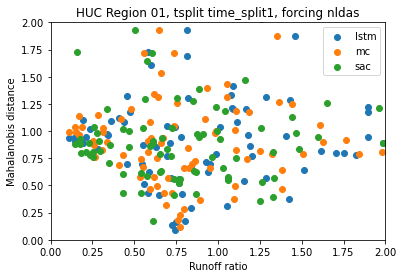

lstm min 0.1272941084100424, mean 1.1131516956108138, max 5.82611101957258
mc min 0.15977520726000444, mean 1.1251804986485598, max 5.538893691747376
sac min 0.08689599833740796, mean 1.1704110095513895, max 5.193697660993914


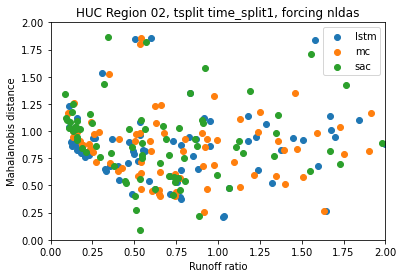

lstm min 0.2540467669598242, mean 1.2111851560323126, max 4.418518525264018
mc min 0.21492928514002216, mean 1.2071296450260942, max 5.048647458655142
sac min 0.05068591545587654, mean 1.1962109002761276, max 4.252447613446197


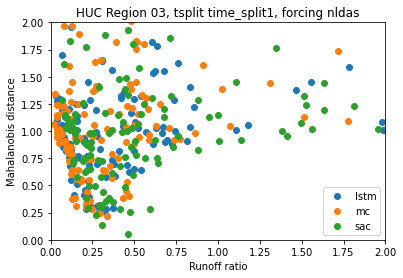

lstm min 0.08852667507442498, mean 1.1097892828743177, max 4.502302107608347
mc min 0.04291974305190356, mean 1.1092188734568678, max 4.605069631397163
sac min 0.1698888978252651, mean 1.0885725358063303, max 5.0876108652097916


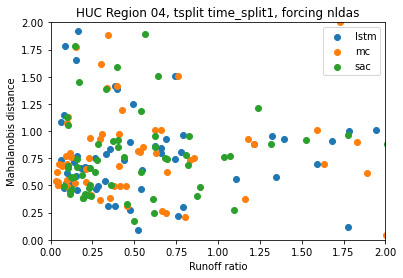

lstm min 0.3296662052283306, mean 1.2205186088514604, max 4.160362894979568
mc min 0.3098892419368143, mean 1.215332100580544, max 4.142208512583664
sac min 0.09858903635470724, mean 1.1778188800024227, max 4.505585590952629


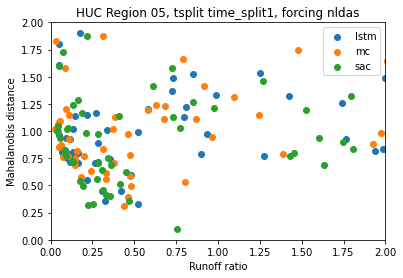

lstm min 0.17038845406526815, mean 1.2033423702436128, max 4.324565985652839
mc min 0.23276177529105063, mean 1.2117306726806838, max 4.2901435071488105
sac min 0.09787660639975407, mean 1.2099900138538113, max 4.275337588545898


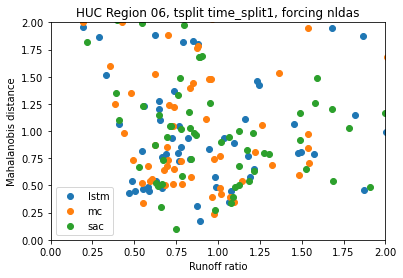

lstm min 0.09336263926274493, mean 0.9479999310872379, max 7.069475169959714
mc min 0.07470510699349091, mean 0.9736444942456377, max 6.547129850543242
sac min 0.1435466652593183, mean 0.8593456125513224, max 10.518035111027737


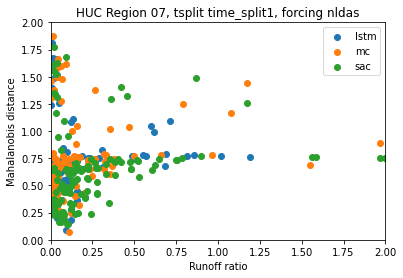

lstm min 0.03627702980682643, mean 1.0086125847697631, max 9.310381726106625
mc min 0.030026119972228083, mean 1.0743467809139249, max 7.880742120949457
sac min 0.20544531507947855, mean 1.2054840598538468, max 5.1980981251262435


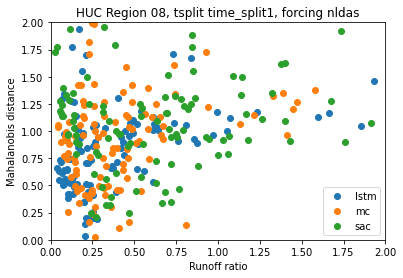

lstm min 0.13858160353591648, mean 0.9886770596455818, max 5.458680020548121
mc min 0.10795576128664933, mean 1.0003938492348285, max 5.451223202614141
sac min 0.18502082629844072, mean 0.9865030174466419, max 5.450212517852281


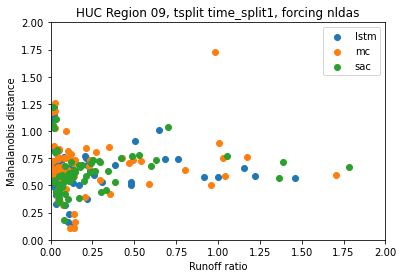

lstm min 0.39955777050607005, mean 1.1533654998949157, max 4.791795657375458
mc min 0.11748310793328037, mean 1.1425380075325935, max 4.78703991233783
sac min 0.3669749027685386, mean 1.1273063667813696, max 4.791860298515338


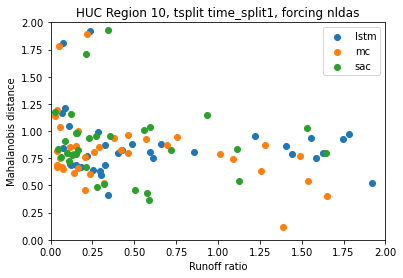

lstm min 0.08208437357762194, mean 1.1603722970516195, max 4.778703169814194
mc min 0.14332589637599727, mean 1.200136724379499, max 4.780859602408497
sac min 0.19161486556954496, mean 1.1863030063019009, max 4.783123917236611


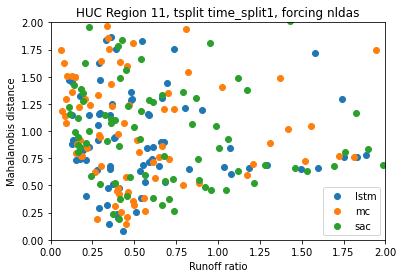

lstm min 0.06051915076631586, mean 1.0672147398514116, max 6.983618012361727
mc min 0.1290020113383395, mean 1.0287703821578453, max 7.625655999453653
sac min 0.026086018840601445, mean 0.9867109382229755, max 7.505608925595345


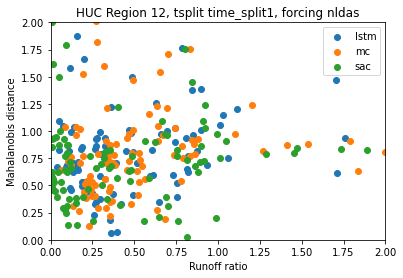

lstm min 0.29690592235139757, mean 1.1585326134165976, max 4.523572666987957
mc min 0.2374776305476258, mean 1.1610623613598987, max 4.516415353350247
sac min 0.26592899457311764, mean 1.1569258718557753, max 4.4998827458794555


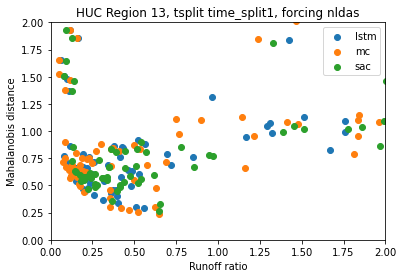

lstm min 0.013494237723900713, mean 0.9610827644428976, max 5.228932981808838
mc min 0.2663470933227133, mean 0.951872126848874, max 5.659473786886645
sac min 0.18559800316464606, mean 1.0155481146441703, max 4.848560358923966


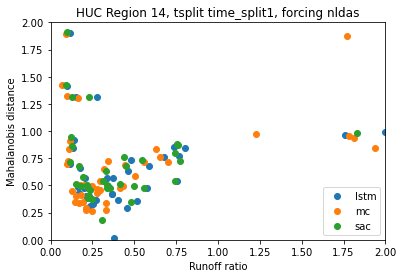

lstm min 0.22424132912108577, mean 1.0899982404576407, max 6.493193726385993
mc min 0.13691483763559298, mean 1.060526506273519, max 6.599540637977103
sac min 0.16111569255979485, mean 0.9056716337046367, max 10.187048275533035


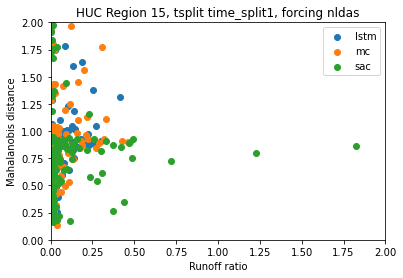

lstm min 0.09951843628038587, mean 1.075494501443189, max 5.621272506101514
mc min 0.1437705565653917, mean 1.1113437802974004, max 5.216607770424037
sac min 0.2541445777569284, mean 1.078256375097728, max 5.7917389068758816


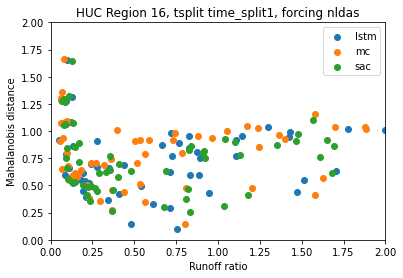

lstm min 0.2918368658789285, mean 1.1466391349996592, max 4.385586338029834
mc min 0.28634439717756877, mean 1.1585674432233122, max 4.372565484589446
sac min 0.2847734340018529, mean 1.123239332493439, max 4.657863625859744


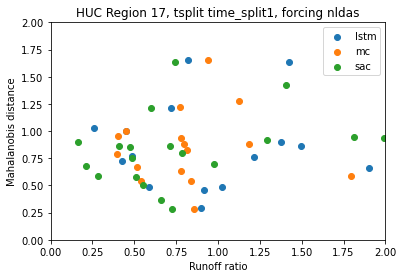

lstm min 0.07401870877732977, mean 0.9481004984797274, max 6.9192376994019895
mc min 0.1651890224089043, mean 1.0568386389284512, max 6.116194763625647
sac min 0.12181395207009812, mean 0.8882732855526897, max 6.31062255839363


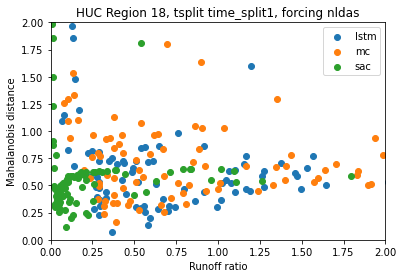

In [25]:
# Plot a distribution, with a point on it, just for an example:
for r in huc_regions:
    for tsplt in ['time_split1', 'time_split2']:
        for forcing_type in forcing_products:
            spex = get_specifications(tsplt, forcing_type)
            for basin_0str in spex["basin_list"]:


                ########################################################
                ######     THIS IS A TEMPORARY HACK     ################
                ######     REPLACE WITH A LOOP OVER REGIONS    #########
                ########################################################
                if get_basin_region(pd_attributes, basin_0str) != r:
                    continue


                for model in spex["models"]:
                    md = events_results[r][tsplt][forcing_type][basin_0str][f"MD_{model}"]
                    rr = events_results[r][tsplt][forcing_type][basin_0str][f"RR_{model}"]
                    plt.scatter(rr,md, label=model)
                    print(f"{model} min {np.min(md)}, mean {np.mean(md)}, max {np.max(md)}")
                plt.xlim([0,2])
                plt.ylim([0,2])
                plt.ylabel("Mahalanobis distance")
                plt.xlabel("Runoff ratio")
                plt.title(f"HUC Region {r}, tsplit {tsplt}, forcing {forcing_type}")
                plt.legend()
                plt.show()
                plt.close()
                break
            break
        break

In [26]:
events_results[r][tsplt][forcing_type][basin_0str].MD_sac

25      0.586226
57      0.589819
106     1.857160
134     0.506637
168     0.538384
          ...   
3406    0.350283
3433    0.625934
3505    0.645194
3552    0.620762
3614    0.582446
Name: MD_sac, Length: 123, dtype: float64

In [27]:
def get_cum_dist_x_y(series):
    x = list(series)
    y = list(range(len(x)))
    for i, _ in enumerate(y):
        y[i] = y[i]/len(y)
    x.sort()
    return x, y

In [28]:
def calculate_rr_location_within_nn_distribution(rr, rr_dist):
    """
        Args:
            rr (float): A runoff ratio for a particular event. 
            rr_dist (series): a sorted series of runoff ratios

    """

    x,y = get_cum_dist_x_y(rr)

    percentile = None
    
    for i, j in zip(x,y):
        if i > rr:
            percentile = y

    return percentile

In [29]:
from sklearn.metrics import r2_score
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [30]:
print("Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)")



for r in huc_regions:

    print(" \n")
    print(" \n")
    print(f"HUC REGION {r}")
    
    for tsplt in ['time_split1', 'time_split2']:

        spex = get_specifications(tsplt, 'nldas')

        rr_nldas_obs = []
        rr_nldas_lstm = []
        rr_nldas_mc = []
        rr_nldas_sac = []
        rr_daymet_obs = []
        rr_daymet_lstm = []
        rr_daymet_mc = []
        rr_daymet_sac = []

        if tsplt == 'time_split2':
            rr_nldas_nwm = []

        for i, basin_0str in enumerate(spex["basin_list"]):


            ########################################################
            ########################################################
            if get_basin_region(pd_attributes, basin_0str) != r:
                continue


            _nldas = events_results[r][tsplt]['nldas'][basin_0str]
            nn_nldas = np.min([100, _nldas.shape[0]])
            _daymet = events_results[r][tsplt]['daymet'][basin_0str]
            nn_daymet = np.min([100, _daymet.shape[0]])

            if tsplt == 'time_split2':
                if np.isnan(list(_nldas.RR_nwm.values)).sum() == 0:
                    if np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
                        rr_nldas_nwm.extend(list(_nldas.sort_values('MD_obs')['RR_nwm'][:nn_nldas]))                
                        rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
                        rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
                        rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
                        rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas])) 
            elif np.isnan(list(_nldas.RR_obs.values)).sum() == 0:
                rr_nldas_obs.extend(list(_nldas.sort_values('MD_obs')['RR_obs'][:nn_nldas]))
                rr_nldas_lstm.extend(list(_nldas.sort_values('MD_obs')['RR_lstm'][:nn_nldas])) 
                rr_nldas_mc.extend(list(_nldas.sort_values('MD_obs')['RR_mc'][:nn_nldas])) 
                rr_nldas_sac.extend(list(_nldas.sort_values('MD_obs')['RR_sac'][:nn_nldas]))

            if np.isnan(list(_daymet.RR_obs.values)).sum() ==0:
                rr_daymet_obs.extend(list(_daymet.sort_values('MD_obs')['RR_obs'][:nn_daymet]))
                rr_daymet_lstm.extend(list(_daymet.sort_values('MD_obs')['RR_lstm'][:nn_daymet])) 
                rr_daymet_mc.extend(list(_daymet.sort_values('MD_obs')['RR_mc'][:nn_daymet])) 
                rr_daymet_sac.extend(list(_daymet.sort_values('MD_obs')['RR_sac'][:nn_daymet]))

        df = pd.DataFrame(columns=["forcing", "model", "MI", "R2", "n"])
        df.loc[len(df)] = ["NLDAS", "LSTM", 
                 np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3),
                 np.round(r2_score(rr_nldas_lstm, rr_nldas_obs),3),
                 len(rr_nldas_obs)]
        df.loc[len(df)] = ["NLDAS", "MC-LSTM", 
                 np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3),
                 np.round(r2_score(rr_nldas_mc, rr_nldas_obs),3),
                 len(rr_nldas_obs)]
        df.loc[len(df)] = ["NLDAS", "SAC-SMA", 
                 np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3),
                 np.round(r2_score(rr_nldas_sac, rr_nldas_obs),3),
                 len(rr_nldas_obs)]
        if tsplt == 'time_split2':
            df.loc[len(df)] = ["NLDAS", "NWM", 
                 np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3),
                 np.round(r2_score(rr_nldas_nwm, rr_nldas_obs),3),
                 len(rr_nldas_obs)]
        df.loc[len(df)] = ["Daymet", "LSTM", 
                 np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3),
                 np.round(r2_score(rr_daymet_lstm, rr_daymet_obs),3),
                 len(rr_daymet_obs)]
        df.loc[len(df)] = ["Daymet", "MC-LSTM", 
                 np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3),
                 np.round(r2_score(rr_daymet_mc, rr_daymet_obs),3),
                 len(rr_daymet_obs)]
        df.loc[len(df)] = ["Daymet", "SAC-SMA", 
                 np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3),
                 np.round(r2_score(rr_daymet_sac, rr_daymet_obs),3),
                 len(rr_daymet_obs)]
        print(f"For {tsplt}")
        print("Mutual information between observed and predicted Runoff Ratios")
        print(f"{len(rr_nldas_obs)} total events with NLDAS")
        print("NLDAS LSTM", np.round(calc_MI(rr_nldas_lstm, rr_nldas_obs, 100),3))
        print("NLDAS MC-LSTM", np.round(calc_MI(rr_nldas_mc, rr_nldas_obs, 100),3))
        print("NLDAS Sac-SMA", np.round(calc_MI(rr_nldas_sac, rr_nldas_obs, 100),3))
        if tsplt == 'time_split2':
            print("NLDAS NWM", np.round(calc_MI(rr_nldas_nwm, rr_nldas_obs, 100),3))
        print(f"{len(rr_daymet_obs)} total events with Daymet")
        print("Daymet LSTM", np.round(calc_MI(rr_daymet_lstm, rr_daymet_obs, 100),3))
        print("Daymet MC-LSTM", np.round(calc_MI(rr_daymet_mc, rr_daymet_obs, 100),3))
        print("Daymet Sac-SMA", np.round(calc_MI(rr_daymet_sac, rr_daymet_obs, 100),3))
        print(" ")
        print(df)

Event based analysis (Note: an event is defined by the magnitude of precipitation, not runoff)
 

 

HUC REGION 01
For time_split1
Mutual information between observed and predicted Runoff Ratios
1681 total events with NLDAS
NLDAS LSTM 0.841
NLDAS MC-LSTM 0.832
NLDAS Sac-SMA 0.74
2200 total events with Daymet
Daymet LSTM 1.082
Daymet MC-LSTM 0.943
Daymet Sac-SMA 0.632
 
  forcing    model     MI     R2     n
0   NLDAS     LSTM  0.841  0.866  1681
1   NLDAS  MC-LSTM  0.832  0.879  1681
2   NLDAS  SAC-SMA  0.740  0.845  1681
3  Daymet     LSTM  1.082  0.804  2200
4  Daymet  MC-LSTM  0.943  0.757  2200
5  Daymet  SAC-SMA  0.632  0.536  2200
For time_split2
Mutual information between observed and predicted Runoff Ratios
1875 total events with NLDAS
NLDAS LSTM 0.294
NLDAS MC-LSTM 0.317
NLDAS Sac-SMA 0.233
NLDAS NWM 0.323
1900 total events with Daymet
Daymet LSTM 0.821
Daymet MC-LSTM 0.819
Daymet Sac-SMA 0.579
 
  forcing    model     MI     R2     n
0   NLDAS     LSTM  0.294  0.885  1875
1  

For time_split1
Mutual information between observed and predicted Runoff Ratios
183 total events with NLDAS
NLDAS LSTM 0.867
NLDAS MC-LSTM 0.801
NLDAS Sac-SMA 0.572
200 total events with Daymet
Daymet LSTM 0.775
Daymet MC-LSTM 0.772
Daymet Sac-SMA 0.96
 
  forcing    model     MI     R2    n
0   NLDAS     LSTM  0.867 -0.895  183
1   NLDAS  MC-LSTM  0.801  0.556  183
2   NLDAS  SAC-SMA  0.572  0.262  183
3  Daymet     LSTM  0.775  0.592  200
4  Daymet  MC-LSTM  0.772  0.506  200
5  Daymet  SAC-SMA  0.960  0.269  200
For time_split2
Mutual information between observed and predicted Runoff Ratios
200 total events with NLDAS
NLDAS LSTM 0.545
NLDAS MC-LSTM 0.422
NLDAS Sac-SMA 0.32
NLDAS NWM 0.52
200 total events with Daymet
Daymet LSTM 1.127
Daymet MC-LSTM 1.098
Daymet Sac-SMA 0.691
 
  forcing    model     MI     R2    n
0   NLDAS     LSTM  0.545 -3.119  200
1   NLDAS  MC-LSTM  0.422 -7.204  200
2   NLDAS  SAC-SMA  0.320  0.126  200
3   NLDAS      NWM  0.520 -3.907  200
4  Daymet     LSTM 

For time_split2
Mutual information between observed and predicted Runoff Ratios
500 total events with NLDAS
NLDAS LSTM 0.497
NLDAS MC-LSTM 0.509
NLDAS Sac-SMA 0.498
NLDAS NWM 0.543
500 total events with Daymet
Daymet LSTM 1.142
Daymet MC-LSTM 1.049
Daymet Sac-SMA 1.199
 
  forcing    model     MI     R2    n
0   NLDAS     LSTM  0.497  0.942  500
1   NLDAS  MC-LSTM  0.509  0.865  500
2   NLDAS  SAC-SMA  0.498  0.767  500
3   NLDAS      NWM  0.543  0.229  500
4  Daymet     LSTM  1.142  0.866  500
5  Daymet  MC-LSTM  1.049  0.843  500
6  Daymet  SAC-SMA  1.199  0.689  500
 

 

HUC REGION 17
For time_split1
Mutual information between observed and predicted Runoff Ratios
3304 total events with NLDAS
NLDAS LSTM 0.92
NLDAS MC-LSTM 0.778
NLDAS Sac-SMA 0.747
6771 total events with Daymet
Daymet LSTM 1.074
Daymet MC-LSTM 0.904
Daymet Sac-SMA 0.813
 
  forcing    model     MI     R2     n
0   NLDAS     LSTM  0.920  0.926  3304
1   NLDAS  MC-LSTM  0.778  0.864  3304
2   NLDAS  SAC-SMA  0.747  0.8

In [31]:
# Q - Q plots.

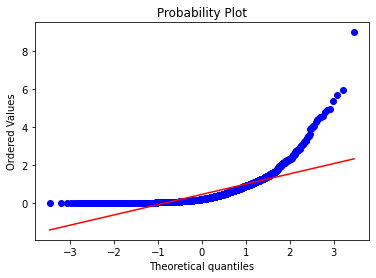

In [32]:
stats.probplot(rr_daymet_obs, dist="norm", plot=pylab)
pylab.show()

In [33]:
import statsmodels.api as sm

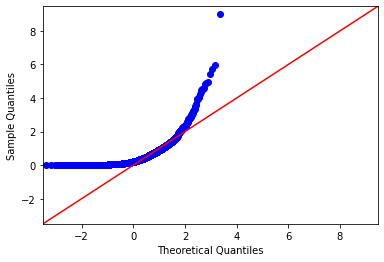

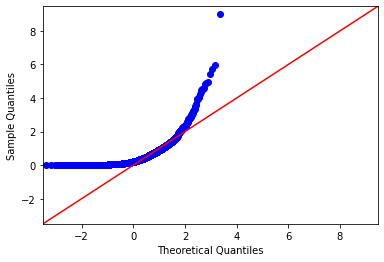

In [34]:
sm.qqplot(np.array(rr_daymet_obs), line ='45')

# Calculate stats for each event on only the 100 closest events

In [35]:
event_stats_100_nearest_neibors_region_file = "event_stats_100_nearest_neibors_region.pkl"

if True:
    with open(event_stats_100_nearest_neibors_region_file, "rb") as fb:
        event_100 = pkl.load(fb)
else:
    event_100 = {r:{'time_split1':{'nldas':{},
                                'daymet':{}},
                 'time_split2':{'nldas':{},
                                'daymet':{}}} for r in huc_regions}

    for r in huc_regions:
        
        for tsplt in ['time_split2','time_split1']:
            print(tsplt)

            for forcing_type in forcing_products:
                print(forcing_type)

                spex = get_specifications(tsplt, forcing_type)

                for model in spex['models']:
                    print(model)

                    event_100[r][tsplt][forcing_type][model] = {"md_ks":[], "md_mi":[], "md_r2":[], "md_perc":[], 
                                                             "rr_ks":[], "rr_mi":[], "rr_r2":[], "rr_perc":[]}

                    for basin_0str in spex["basin_list"]:


                        ########################################################
                        ########################################################
                        if get_basin_region(pd_attributes, basin_0str) != r:
                            continue


                        # Don't include any models if SAC-SMA is NaN
                        if np.isnan(events_results[r][tsplt][forcing_type][basin_0str][f'MD_sac']).sum() > 0:
                            continue
                        # Don't include any models if Observation is NaN
                        if np.isnan(events_results[r][tsplt][forcing_type][basin_0str][f'MD_obs']).sum() > 0:
                            continue

                        df = events_results[r][tsplt][forcing_type][basin_0str]

                        md_obs = df[f'MD_obs']
                        rr_obs = df[f'RR_obs']

                        md_model = df[f'MD_{model}']
                        rr_model = df[f'RR_{model}']

                        for event in df.index.values:

                            this_event_obs_md = md_model[event]
                            this_event_model_md = md_model[event]

                            this_event_obs_rr = rr_obs[event]
                            this_event_model_rr = rr_model[event]

                            # Now find 100 closest events!

                            md_model_100 = md_model.iloc[(df[f'MD_{model}']-this_event_model_md).abs().argsort()[:100]]
                            model_indx = md_model_100.index.values
                            md_obs_100 = md_model.iloc[(df[f'MD_obs']-this_event_model_md).abs().argsort()[:100]]
                            obs_indx = md_model_100.index.values

                            rr_model_100 = df.loc[model_indx, f'RR_{model}']
                            rr_obs_100 = df.loc[obs_indx, f'RR_obs']

                            # For the R2 metric, there needs to be a 1 to 1 correspondence between events
                            # it is not 'simple' the distributions we are interested in,
                            #     but the ability to explain the variance of observation with the model.
                            rr_obs_100_mod = df.loc[model_indx, f'RR_obs']
                            md_obs_100_mod = df.loc[model_indx, f'MD_obs']

                            event_100[r][tsplt][forcing_type][model]["md_ks"].append(kstest(md_model_100, md_obs_100)[0])
                            event_100[r][tsplt][forcing_type][model]["md_mi"].append(calc_MI(md_model_100, md_obs_100, 100))

                            event_100[r][tsplt][forcing_type][model]["rr_ks"].append(kstest(rr_model_100, rr_obs_100)[0])
                            event_100[r][tsplt][forcing_type][model]["rr_mi"].append(calc_MI(rr_model_100, rr_obs_100, 100))

                            # NOTE: The R2 score needs to have the same events to make a 1 to 1 correspondence.
                            # NOTE: Could do both for the MI and KS as well...
                            event_100[r][tsplt][forcing_type][model]["md_r2"].append(r2_score(md_model_100, md_obs_100_mod))
                            event_100[r][tsplt][forcing_type][model]["rr_r2"].append(r2_score(rr_model_100, rr_obs_100_mod))

                            event_100[r][tsplt][forcing_type][model]["md_perc"].append(stats.percentileofscore(md_model_100,this_event_model_md))
                            event_100[r][tsplt][forcing_type][model]["rr_perc"].append(stats.percentileofscore(rr_model_100,this_event_model_rr))

    with open(event_stats_100_nearest_neibors_region_file, "wb") as fb:
        pkl.dump(event_100, fb)
        

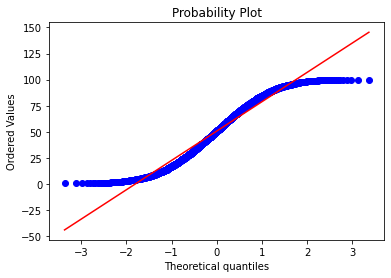

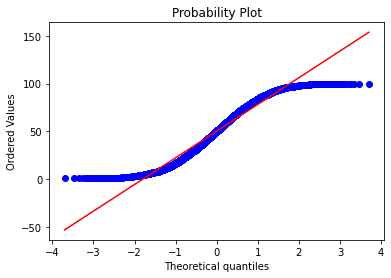

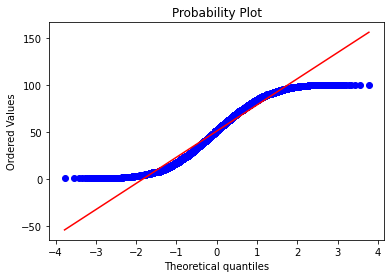

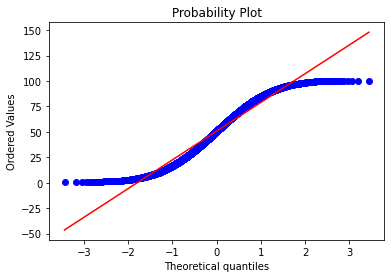

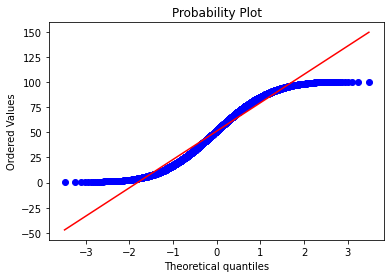

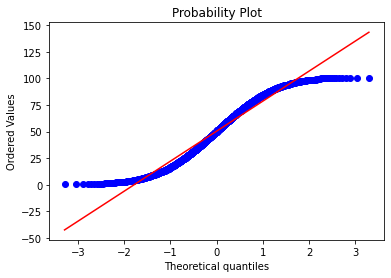

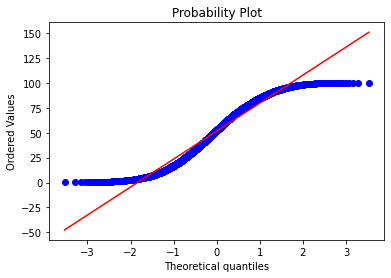

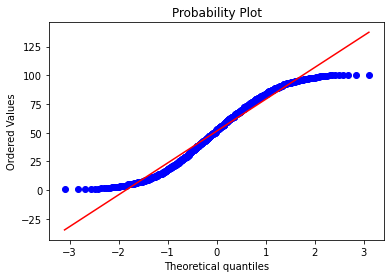

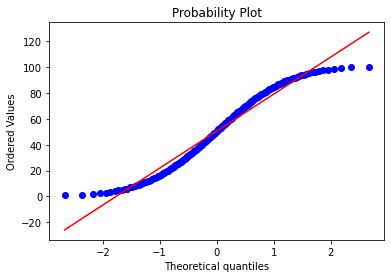

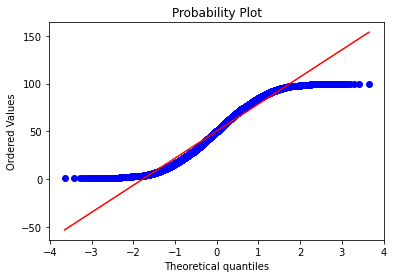

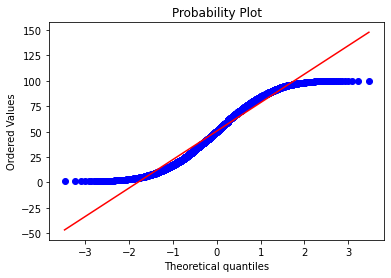

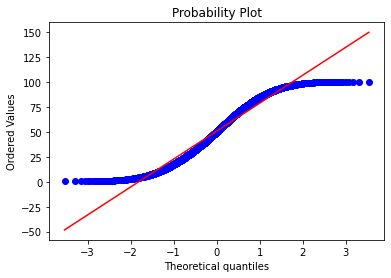

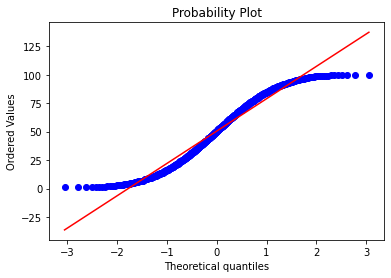

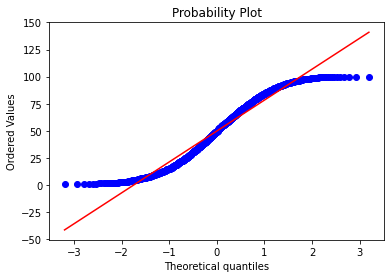

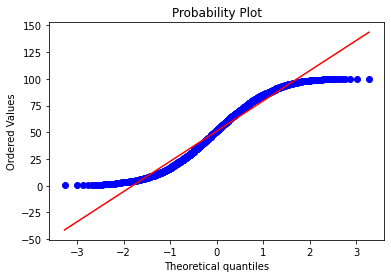

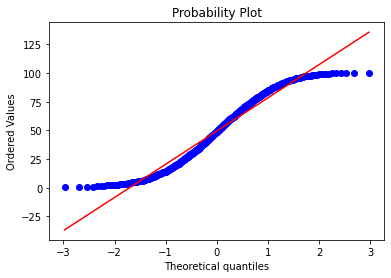

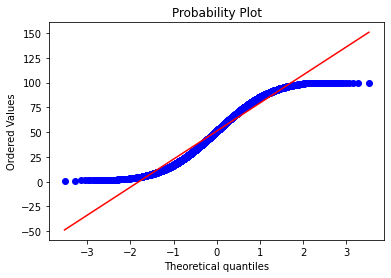

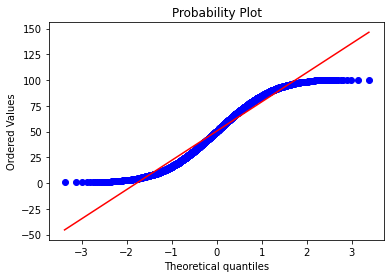

In [36]:
for r in huc_regions:
    stats.probplot(np.array(np.array(event_100[r]['time_split1']["nldas"]["lstm"]["rr_perc"])), dist="norm", plot=pylab)
    pylab.show()

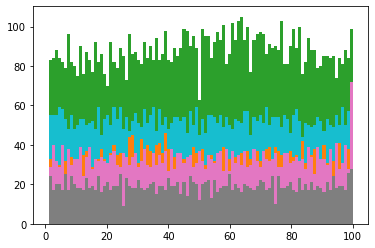

In [37]:
for r in huc_regions:
    plt.hist(np.array(np.array(event_100[r]['time_split1']["nldas"]["lstm"]["rr_perc"])), bins=100)

In [38]:
def make_q_q(array):
    
    bin_percentage_list = [0]
    bin_quantity_list = [0]
    perc_deviation = [0]
    cumulativ_deviation = [0]
    
    for i, p in enumerate(range(10,110,10)):
        
        total_events = array.shape[0]
        
        a = np.where(array > p-10, 1, 0)
        b = np.where(array <= p, 1, 0)
        
        number_in_bin = np.sum(a*b)

        percent_in_bin = number_in_bin / total_events
        
        perc_deviation.append(percent_in_bin - (1/10))
        
        bin_quantity_list.append(number_in_bin)
        
        percent_in_previous_bin = bin_percentage_list[i]

        bin_percentage_list.append(percent_in_bin + percent_in_previous_bin)
        
        cumulativ_deviation.append(percent_in_bin + percent_in_previous_bin - ((i+1)/10))
            
    number_in_bins = np.sum(bin_quantity_list)

    return bin_percentage_list, bin_quantity_list, perc_deviation, cumulativ_deviation

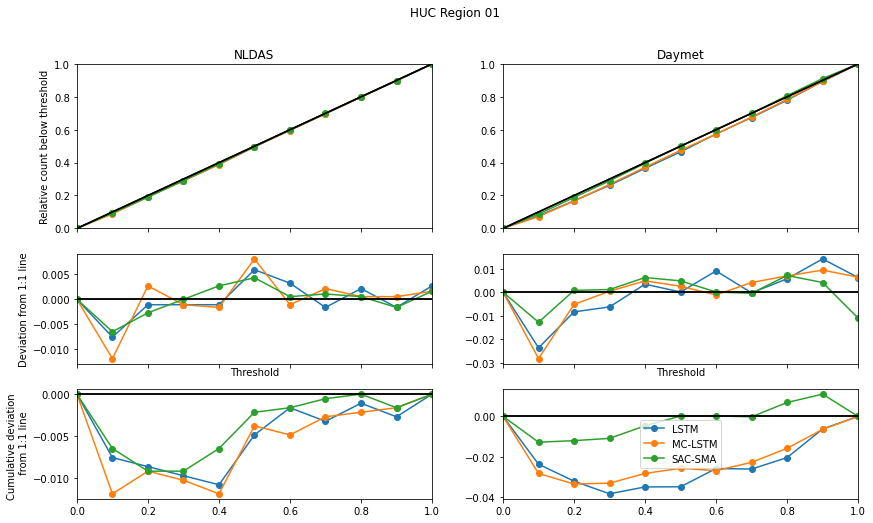

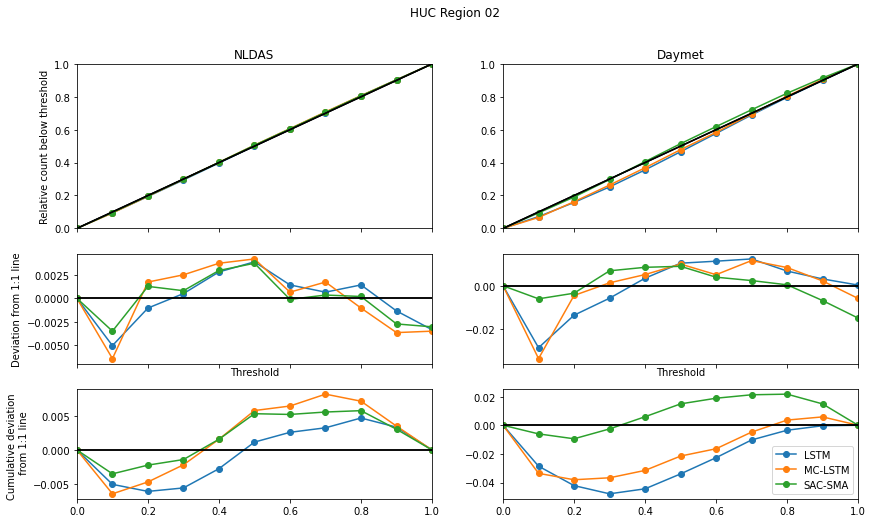

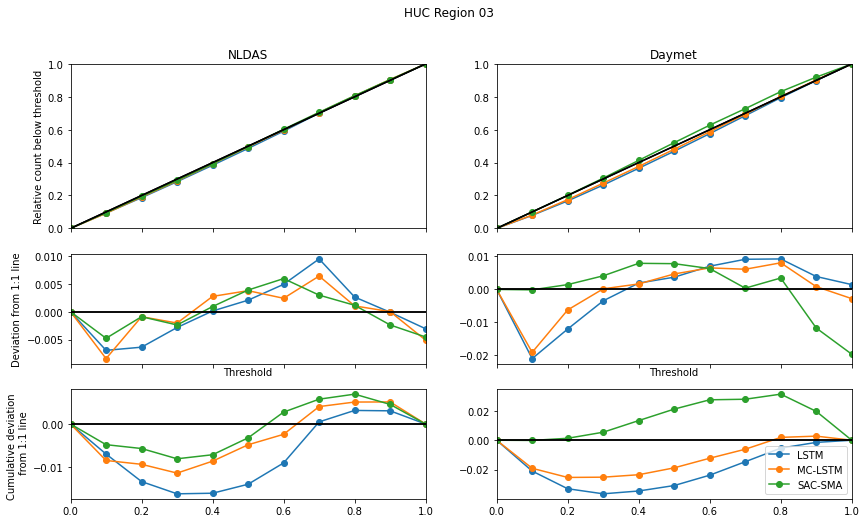

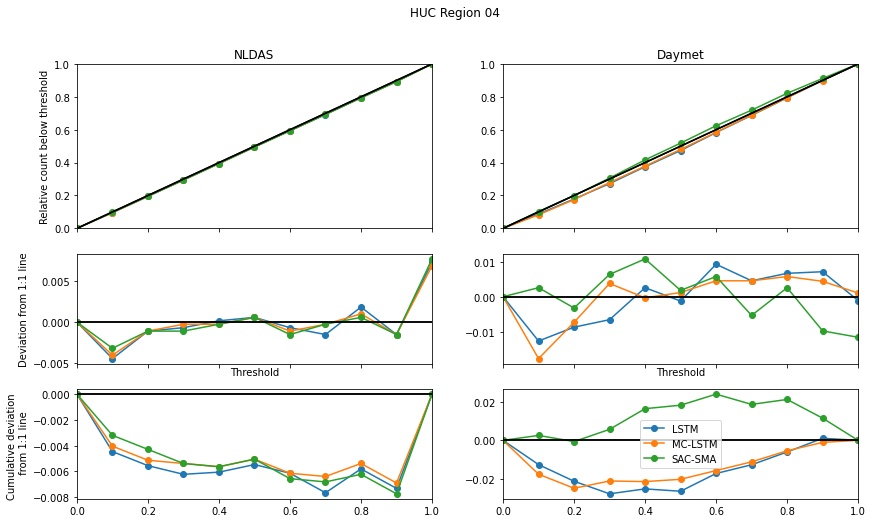

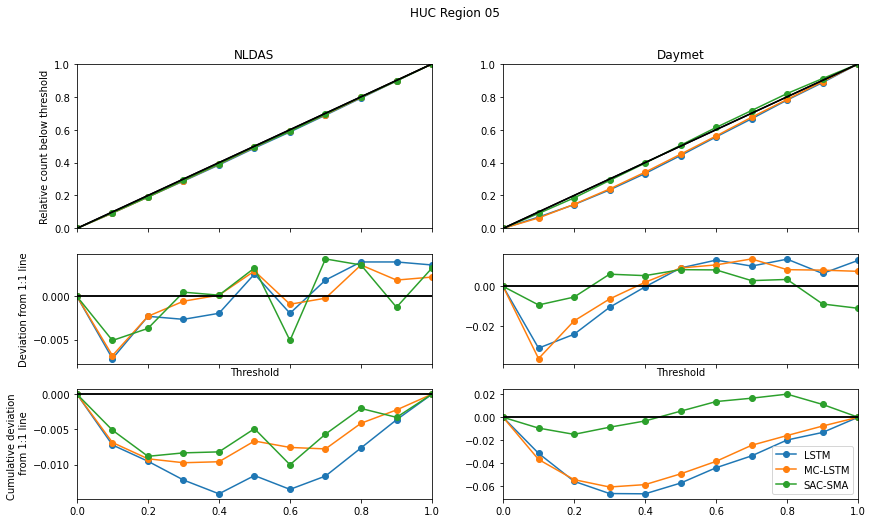

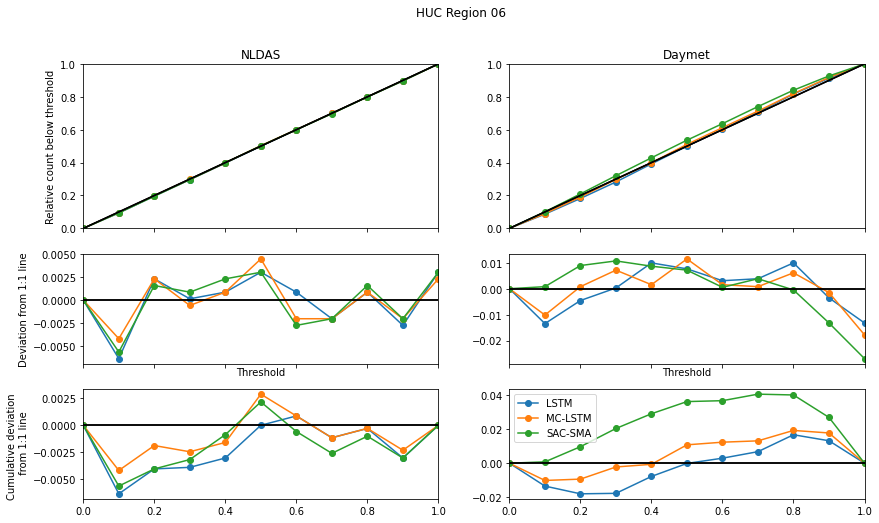

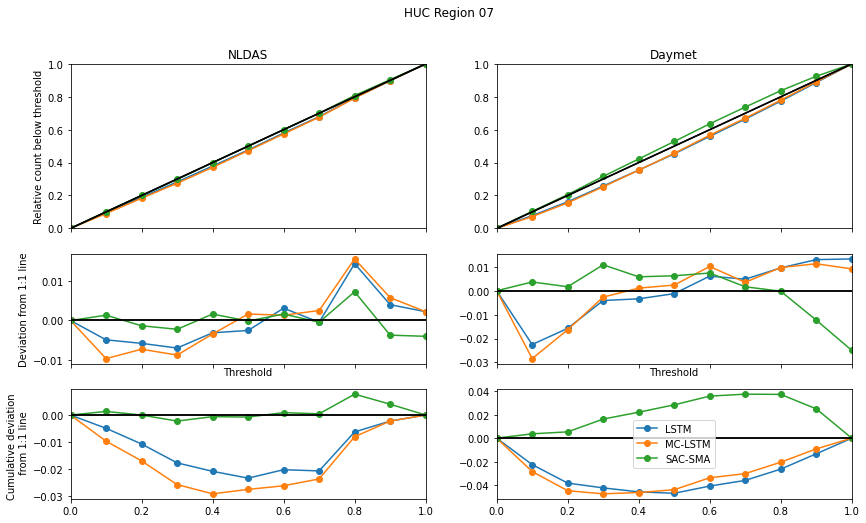

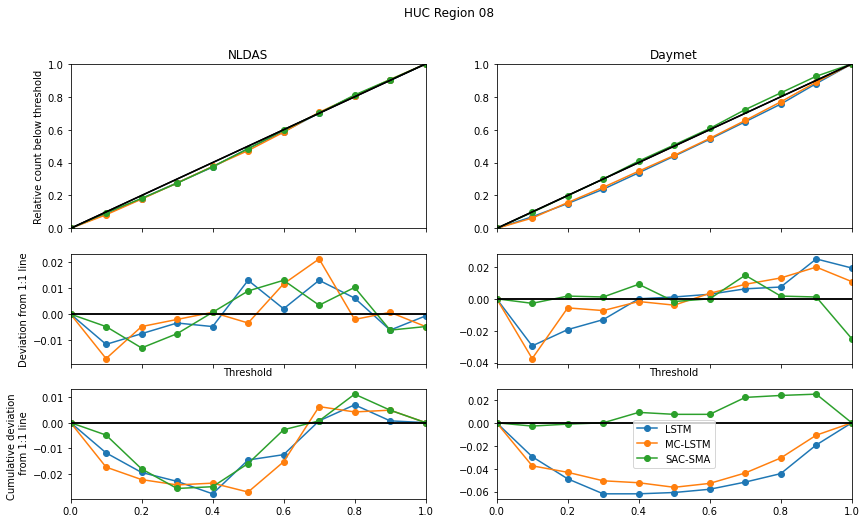

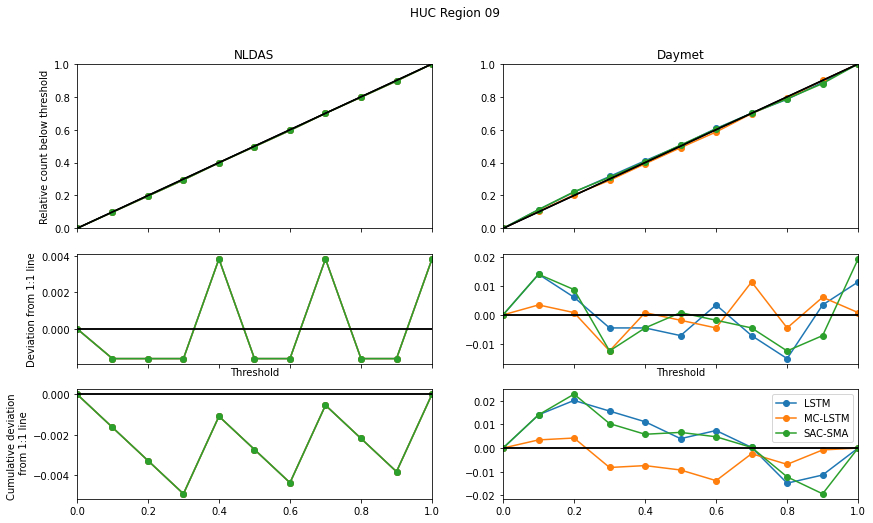

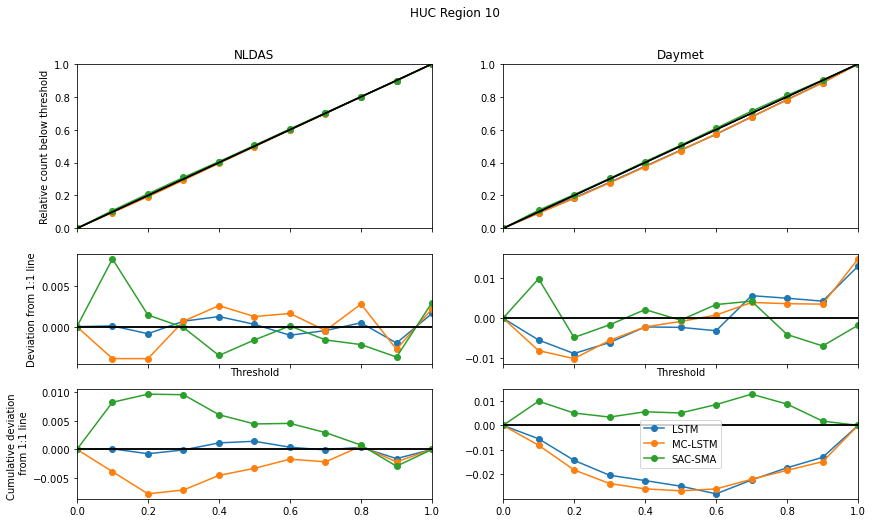

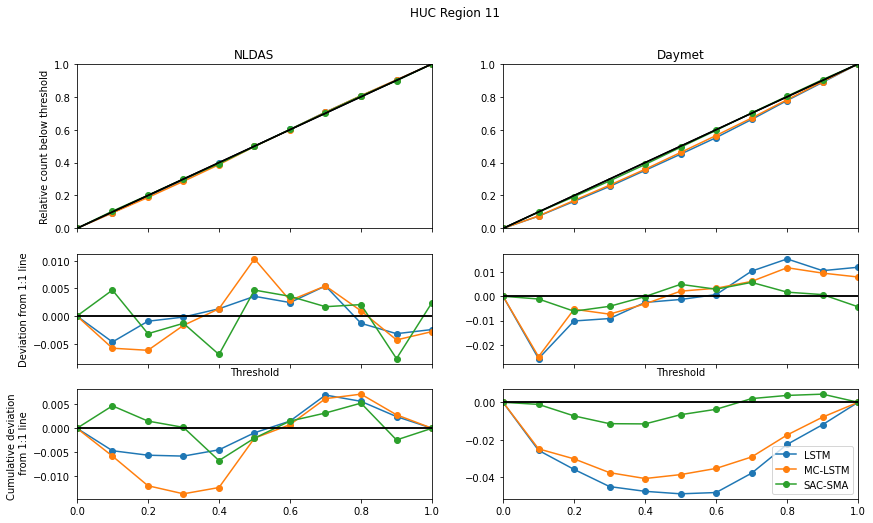

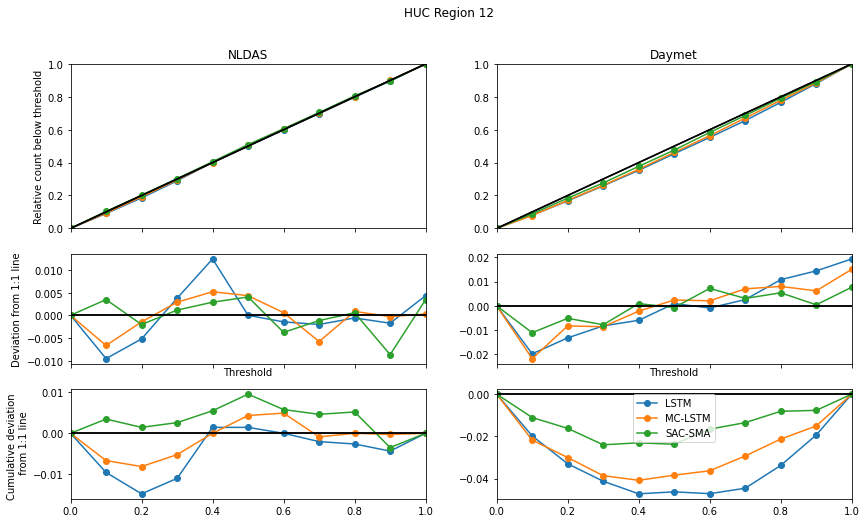

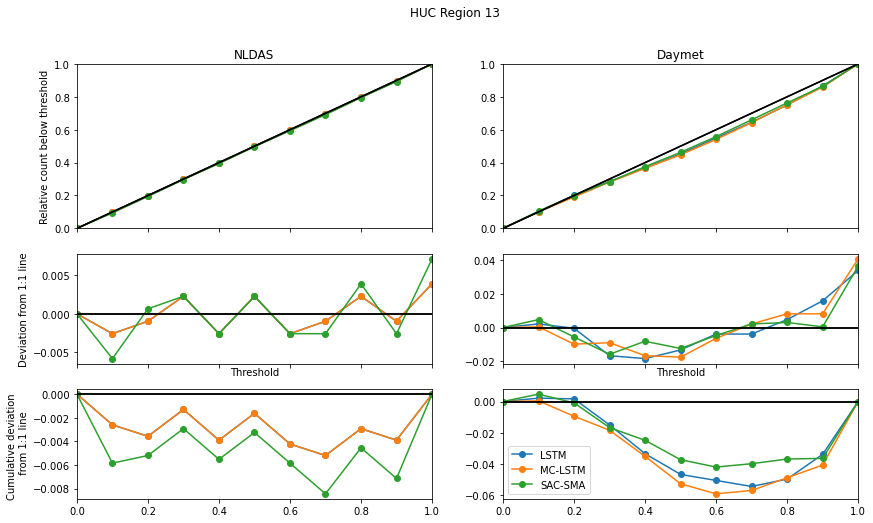

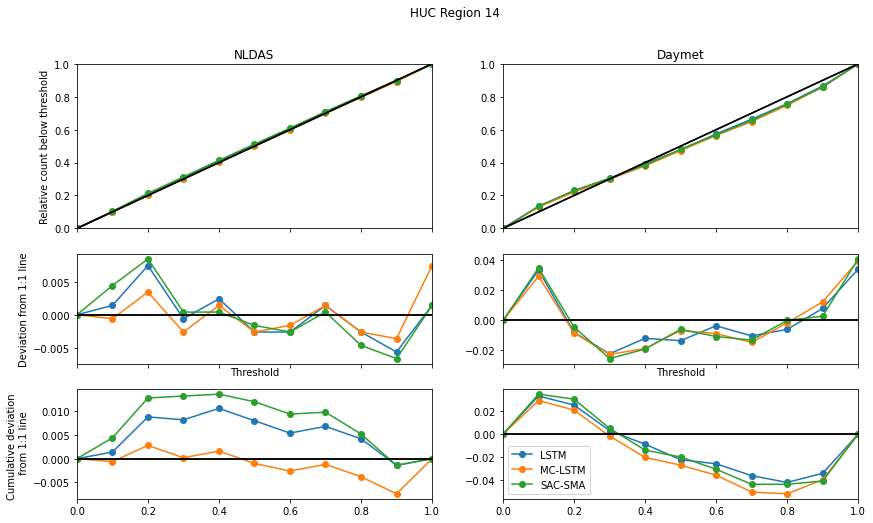

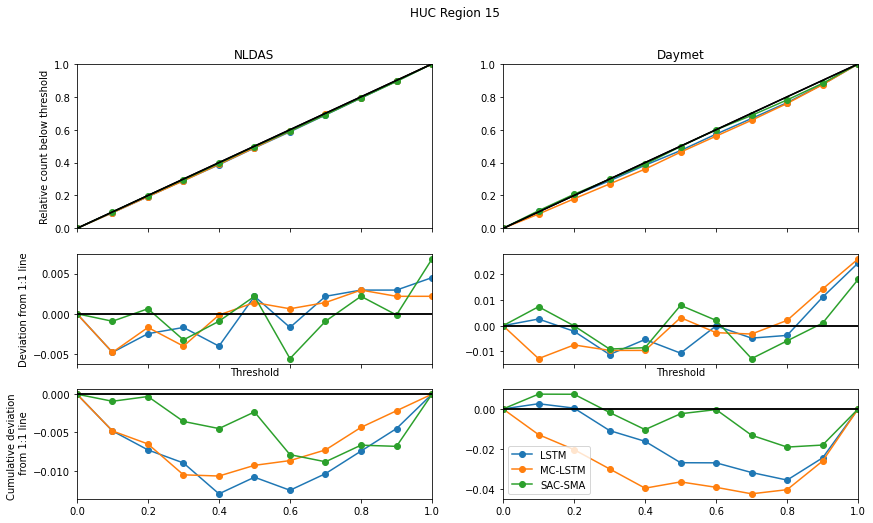

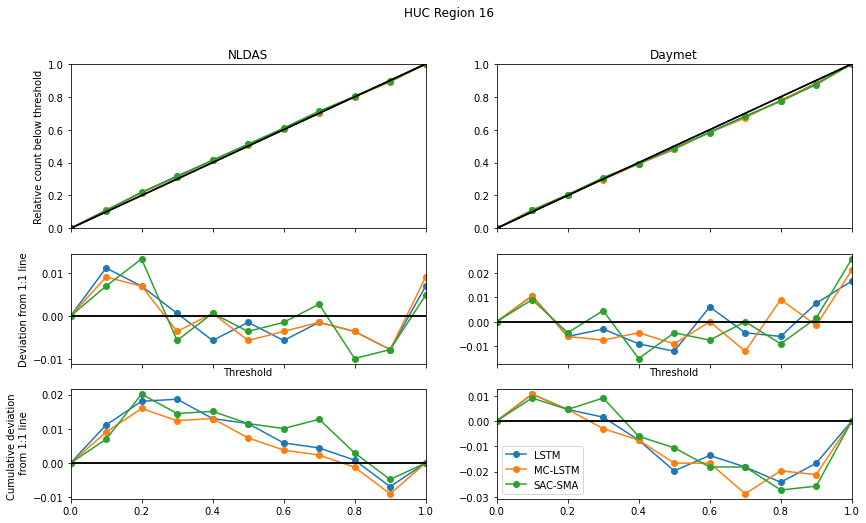

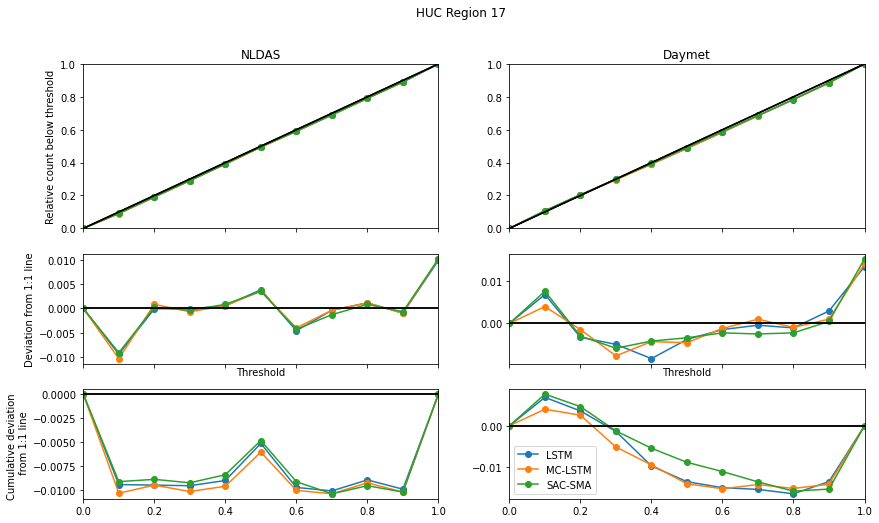

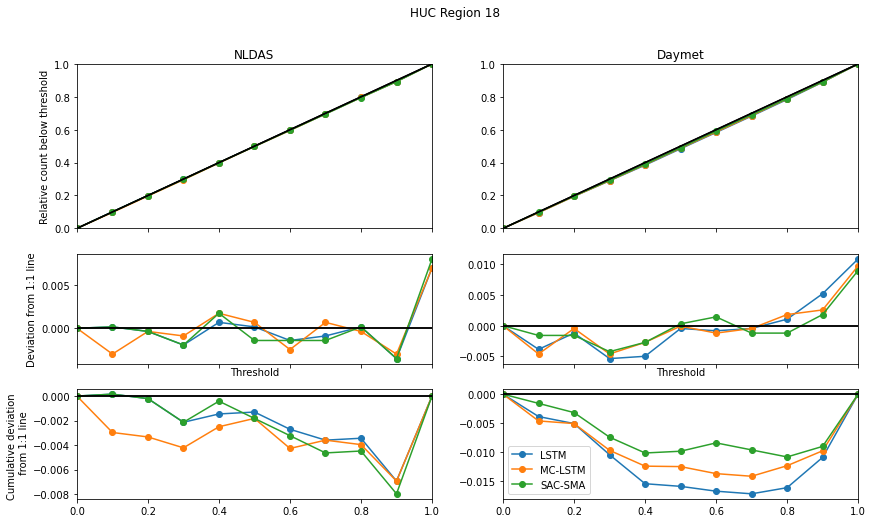

In [41]:
abs_qq_deviate = {r:{'nldas':{m:{'abs':0, 'pos':0, 'neg':0} for m in ["lstm", "mc", "sac"]},
                     'daymet':{m:{'abs':0, 'pos':0, 'neg':0} for m in ["lstm", "mc", "sac"]}} for r in huc_regions}

for r in huc_regions:

    fig, axs = plt.subplots(3,2, sharex=True, sharey=False, figsize=(14,8),gridspec_kw={'height_ratios': [3, 2, 2]})

    for model in ["lstm", "mc", "sac"]:

        perc_rrs, num_rrs, p_dev, c_dev = make_q_q(np.array(event_100[r]['time_split1']["nldas"][model]["rr_perc"]))
        abs_qq_deviate[r]['nldas'][model]['abs'] += np.abs(c_dev).sum()
        abs_qq_deviate[r]['nldas'][model]['pos'] += np.abs(np.where(np.array(c_dev)>0,c_dev,0)).sum()
        abs_qq_deviate[r]['nldas'][model]['neg'] += np.abs(np.where(np.array(c_dev)<0,c_dev,0)).sum()
            
        axs[0,0].plot([i/10 for i in range(11)], perc_rrs, marker="o", label=model)
        axs[1,0].plot([i/10 for i in range(11)], p_dev, marker="o")
        axs[2,0].plot([i/10 for i in range(11)], c_dev, marker="o")
    axs[0,0].set_title("NLDAS")
    axs[0,0].set_xlim([0,1])
    axs[0,0].set_ylim([0,1])
    axs[0,0].set_ylabel("Relative count below threshold")
    axs[1,0].set_ylabel("Deviation from 1:1 line")
    axs[2,0].set_ylabel("Cumulative deviation \n from 1:1 line")
    axs[0,0].plot([[0,0],[1,1]], "k")
    axs[1,0].plot([[0,0],[0,0]], "k")
    axs[2,0].plot([[0,0],[0,0]], "k")
    axs[1,0].set_xlabel("Threshold")
    #----------------------------------------------------------------------------
    for model in ["lstm", "mc", "sac"]:

        perc_rrs, num_rrs, p_dev, c_dev = make_q_q(np.array(event_100[r]['time_split1']["daymet"][model]["rr_perc"]))
        
        abs_qq_deviate[r]['daymet'][model]['abs'] += np.abs(c_dev).sum()
        abs_qq_deviate[r]['daymet'][model]['pos'] += np.abs(np.where(np.array(c_dev)>0,c_dev,0)).sum()
        abs_qq_deviate[r]['daymet'][model]['neg'] += np.abs(np.where(np.array(c_dev)<0,c_dev,0)).sum()
        
        axs[0,1].plot([i/10 for i in range(11)], perc_rrs, marker="o", label=model)
        axs[1,1].plot([i/10 for i in range(11)], p_dev, marker="o")
        axs[2,1].plot([i/10 for i in range(11)], c_dev, marker="o")
    axs[0,1].set_title("Daymet")
    axs[0,1].set_xlim([0,1])
    axs[0,1].set_ylim([0,1])
    axs[0,1].plot([[0,0],[1,1]], "k")
    axs[1,1].plot([[0,0],[0,0]], "k")
    axs[2,1].plot([[0,0],[0,0]], "k")
    axs[1,1].set_xlabel("Threshold")
    
    plt.legend([spex['labelz'][model] for model in ["lstm", "mc", "sac"]])
    plt.suptitle(f"HUC Region {r}")
    plt.show()
    plt.close()
    

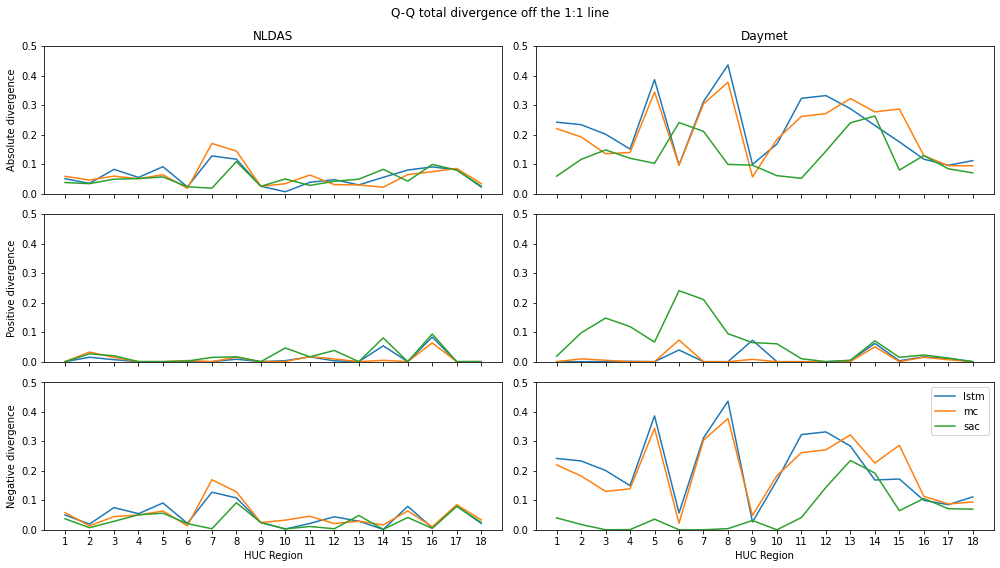

In [45]:
fig, axs = plt.subplots(3,2, sharex=True, sharey=False, figsize=(14,8),gridspec_kw={'height_ratios': [1, 1, 1]})
x = [i+1 for i in range(len(list(huc_regions)))]
div_name_map = {'abs':'Absolute', 'pos':'Positive', 'neg':'Negative'}
for i, div_type in enumerate(['abs', 'pos', 'neg']):
    
    for m in ["lstm", "mc", "sac"]:
        axs[i,1].plot(x, [abs_qq_deviate[r]['daymet'][m][div_type] for r in huc_regions], label=m)
        if i == 0:
            axs[i,1].set_title(f"Daymet")
        if i == 2:
            axs[i,1].set_xlabel("HUC Region")
        axs[i,1].set_xticks(np.arange(min(x), max(x)+1, 1.0))
        axs[i,1].set_ylim([0,.5])
    
    for m in ["lstm", "mc", "sac"]:
        axs[i,0].plot(x, [abs_qq_deviate[r]['nldas'][m][div_type] for r in huc_regions], label=m)
        axs[i,0].set_ylabel(f"{div_name_map[div_type]} divergence")
        if i == 0:
            axs[i,0].set_title(f"NLDAS")
        axs[i,0].set_xticks(np.arange(min(x), max(x)+1, 1.0))
        axs[i,0].set_ylim([0,.5])
        if i == 2:
            axs[i,0].set_xlabel("HUC Region")
            
plt.suptitle("Q-Q total divergence off the 1:1 line")
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

In [40]:
df_mean_dict = {r: pd.DataFrame(columns=["time_split", "forcing", "model",
                               "RR_MI", "RR_KS", "RR_R2", 
                               "MD_MI", "MD_KS", "MD_R2", "n"]) for r in huc_regions}

for r in huc_regions:

    print(f"HUC REGION: {r}")
    
    for tsplt in ['time_split1','time_split2']:

        for forcing_type in forcing_products:

            spex = get_specifications(tsplt, forcing_type)

            for model in spex['models']:

                df_mean_dict[r].loc[len(df_mean_dict[r])] = [tsplt, forcing_type, model, 
                         np.mean(event_100[r][tsplt][forcing_type][model]["rr_mi"]),
                         np.mean(event_100[r][tsplt][forcing_type][model]["rr_ks"]),
                         np.mean(event_100[r][tsplt][forcing_type][model]["rr_r2"]),
                         np.mean(event_100[r][tsplt][forcing_type][model]["md_mi"]),
                         np.mean(event_100[r][tsplt][forcing_type][model]["md_ks"]),
                         np.mean(event_100[r][tsplt][forcing_type][model]["md_r2"]),
                         len(event_100[r][tsplt][forcing_type][model]["rr_mi"])]

    print(df_mean_dict[r])

HUC REGION: 02
     time_split forcing model     RR_MI     RR_KS     RR_R2     MD_MI  \
0   time_split1   nldas  lstm  1.661578  0.114887  0.891947  2.847982   
1   time_split1   nldas    mc  1.605952  0.121571  0.868525  2.810485   
2   time_split1   nldas   sac  1.522589  0.128833  0.739026  2.838444   
3   time_split1  daymet  lstm  2.526010  0.133675  0.726893  2.895507   
4   time_split1  daymet    mc  2.494118  0.147411  0.674063  2.903977   
5   time_split1  daymet   sac  2.430594  0.276686  0.313809  2.923444   
6   time_split2   nldas   nwm  1.871687  0.126077  0.698097  2.837316   
7   time_split2   nldas  lstm  1.862915  0.125728  0.840453  2.853718   
8   time_split2   nldas    mc  1.877209  0.120463  0.787096  2.895669   
9   time_split2   nldas   sac  1.812934  0.153589  0.630905  2.867529   
10  time_split2  daymet  lstm  2.562786  0.159153  0.714123  2.852940   
11  time_split2  daymet    mc  2.524292  0.165048  0.644216  2.888073   
12  time_split2  daymet   sac  2.490

     time_split forcing model     RR_MI     RR_KS     RR_R2     MD_MI  \
0   time_split1   nldas  lstm  1.511216  0.179809  0.231591  2.850002   
1   time_split1   nldas    mc  1.476152  0.212154 -2.121086  2.811058   
2   time_split1   nldas   sac  1.419709  0.169096  0.170291  2.748253   
3   time_split1  daymet  lstm  2.295626  0.208694 -0.355207  2.724791   
4   time_split1  daymet    mc  2.258157  0.249305 -0.797641  2.875224   
5   time_split1  daymet   sac  2.313480  0.315504 -0.798105  2.858565   
6   time_split2   nldas   nwm  1.549101  0.159234  0.283608  2.594836   
7   time_split2   nldas  lstm  1.775025  0.228211  0.092306  2.624337   
8   time_split2   nldas    mc  1.691894  0.239067 -1.137484  2.610457   
9   time_split2   nldas   sac  1.570764  0.237244 -2.533415  2.516003   
10  time_split2  daymet  lstm  2.527454  0.211673 -0.440589  2.768723   
11  time_split2  daymet    mc  2.510876  0.282646 -1.661066  2.797261   
12  time_split2  daymet   sac  2.416630  0.379934 -

     time_split forcing model     RR_MI     RR_KS      RR_R2     MD_MI  \
0   time_split1   nldas  lstm  1.318605  0.240315  -0.941153  2.729719   
1   time_split1   nldas    mc  1.267034  0.283543  -2.070109  2.609039   
2   time_split1   nldas   sac  1.256705  0.278072  -4.760903  2.612451   
3   time_split1  daymet  lstm  1.929852  0.259375  -0.326219  2.677067   
4   time_split1  daymet    mc  1.916398  0.356068  -1.141751  2.709387   
5   time_split1  daymet   sac  1.892475  0.377200  -3.612186  2.728376   
6   time_split2   nldas   nwm  1.461329  0.253099  -7.133415  2.415386   
7   time_split2   nldas  lstm  1.522150  0.295032  -0.447792  2.513706   
8   time_split2   nldas    mc  1.490408  0.291045  -1.391712  2.492229   
9   time_split2   nldas   sac  1.346863  0.314373 -12.003176  2.407986   
10  time_split2  daymet  lstm  2.057484  0.273174  -1.522599  2.592995   
11  time_split2  daymet    mc  2.045386  0.306356  -2.026892  2.558585   
12  time_split2  daymet   sac  1.96316

In [41]:
df_median_dict = {r:pd.DataFrame(columns=["time_split", "forcing", "model",
                           "RR_MI", "RR_KS", "RR_R2", 
                           "MD_MI", "MD_KS", "MD_R2", "n"]) for r in huc_regions}


for r in huc_regions:

    print(f"HUC REGION: {r}")
    
    for tsplt in ['time_split1','time_split2']:

        for forcing_type in forcing_products:

            spex = get_specifications(tsplt, forcing_type)

            for model in spex['models']:

                df_median_dict[r].loc[len(df_mean_dict[r])] = [tsplt, forcing_type, model, 
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["rr_mi"]),3),
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["rr_ks"]),3),
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["rr_r2"]),3),
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["md_mi"]),3),
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["md_ks"]),3),
                         np.round(np.median(event_100[r][tsplt][forcing_type][model]["md_r2"]),3),
                         len(event_100[r][tsplt][forcing_type][model]["rr_mi"])]

    print(df_median_dict[r])

HUC REGION: 02
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2      n
13  time_split2  daymet   sac  2.514   0.28  0.477  2.916   0.27 -6.469  22383
HUC REGION: 16
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2     n
13  time_split2  daymet   sac  2.149   0.18  0.621  2.363   0.13 -1.518  1218
HUC REGION: 14
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2     n
13  time_split2  daymet   sac  2.078   0.18   0.58  2.691   0.09 -0.244  3977
HUC REGION: 17
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2      n
13  time_split2  daymet   sac  2.442   0.15  0.438  2.878   0.11 -0.804  11973
HUC REGION: 13
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2     n
13  time_split2  daymet   sac  2.142   0.21  0.496  2.658   0.14 -2.713  2102
HUC REGION: 04
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2      n
13  time_split2  daymet   sac  2.427   0.27  0.

In [44]:
event_stats_100_rr1_nearest_neibors_region_file = "event_stats_100_rr1_nearest_neibors_region.pkl"
if True:
    with open(event_stats_100_rr1_nearest_neibors_region_file, "rb") as fb:
        event_100_rr1 = pkl.load(fb)
else:
    event_100_rr1 = {r:{'time_split1':{'nldas':{},
                                'daymet':{}},
                 'time_split2':{'nldas':{},
                                'daymet':{}}} for r in huc_regions}

    for r in huc_regions:

        for tsplt in ['time_split2','time_split1']:
            print(tsplt)

            for forcing_type in forcing_products:
                print(forcing_type)

                spex = get_specifications(tsplt, forcing_type)

                for model in spex['models']:
                    print(model)

                    event_100_rr1[r][tsplt][forcing_type][model] = {"md_ks":[], "md_mi":[], "md_r2":[], 
                                                             "rr_ks":[], "rr_mi":[], "rr_r2":[]}

                    for basin_0str in spex["basin_list"]:


                        ########################################################
                        ########################################################
                        if get_basin_region(pd_attributes, basin_0str) != r:
                            continue



                        # Don't include any models if SAC-SMA is NaN
                        if np.isnan(events_results[r][tsplt][forcing_type][basin_0str][f'MD_sac']).sum() > 0:
                            continue
                        # Don't include any models if Observation is NaN
                        if np.isnan(events_results[r][tsplt][forcing_type][basin_0str][f'MD_obs']).sum() > 0:
                            continue

                        df = events_results[r][tsplt][forcing_type][basin_0str]

                        md_obs = df[f'MD_{model}']

                        md_model = df[f'MD_{model}']

                        for event in df.index.values:

                            this_event_obs_md = md_model[event]
                            this_event_model_md = md_model[event]

                            ###################################################
                            ###################################################
                            # Now lets consider events with runoff ratios of 1 or less!
                            if df.loc[event, f'RR_obs'] > 1:
                                continue

                            # Now find 100 closest events!

                            md_model_100 = md_model.iloc[(df[f'MD_{model}']-this_event_model_md).abs().argsort()[:100]]
                            model_indx = md_model_100.index.values
                            md_obs_100 = md_model.iloc[(df[f'MD_obs']-this_event_model_md).abs().argsort()[:100]]
                            obs_indx = md_model_100.index.values

                            rr_model_100 = df.loc[model_indx, f'RR_{model}']
                            rr_obs_100 = df.loc[obs_indx, f'RR_obs']

                            # For the R2 metric, there needs to be a 1 to 1 correspondence between events
                            # it is not 'simple' the distributions we are interested in,
                            #     but the ability to explain the variance of observation with the model.
                            rr_obs_100_mod = df.loc[model_indx, f'RR_obs']
                            md_obs_100_mod = df.loc[model_indx, f'MD_obs']

                            event_100_rr1[r][tsplt][forcing_type][model]["md_ks"].append(kstest(md_model_100, md_obs_100)[0])
                            event_100_rr1[r][tsplt][forcing_type][model]["md_mi"].append(calc_MI(md_model_100, md_obs_100, 100))

                            event_100_rr1[r][tsplt][forcing_type][model]["rr_ks"].append(kstest(rr_model_100, rr_obs_100)[0])
                            event_100_rr1[r][tsplt][forcing_type][model]["rr_mi"].append(calc_MI(rr_model_100, rr_obs_100, 100))

                            # NOTE: The R2 score needs to have the same events to make a 1 to 1 correspondence.
                            # NOTE: Could do both for the MI and KS as well...
                            event_100_rr1[r][tsplt][forcing_type][model]["md_r2"].append(r2_score(md_model_100, md_obs_100_mod))
                            event_100_rr1[r][tsplt][forcing_type][model]["rr_r2"].append(r2_score(rr_model_100, rr_obs_100_mod))

    with open(event_stats_100_rr1_nearest_neibors_region_file, "wb") as fb:
        pkl.dump(event_100_rr1, fb)
        

In [49]:
df_median = {r:pd.DataFrame(columns=["time_split", "forcing", "model",
                           "RR_MI", "RR_KS", "RR_R2", 
                           "MD_MI", "MD_KS", "MD_R2", "n"]) for r in huc_regions}

for r in huc_regions:
    
    print(" \n")
    print(" \n")
    print(f"HUC REGION {r}")

    for tsplt in ['time_split1','time_split2']:

        for forcing_type in forcing_products:

            spex = get_specifications(tsplt, forcing_type)

            for model in spex['models']:

                df_median[r].loc[len(df_median[r])] = [tsplt, forcing_type, model, 
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["rr_mi"]),3),
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["rr_ks"]),3),
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["rr_r2"]),3),
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["md_mi"]),3),
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["md_ks"]),3),
                         np.round(np.median(event_100_rr1[r][tsplt][forcing_type][model]["md_r2"]),3),
                         len(event_100_rr1[r][tsplt][forcing_type][model]["rr_mi"])]

    print(df_median[r])

 

 

HUC REGION 02
     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2      n
0   time_split1   nldas  lstm  1.651  0.110  0.926  2.890   0.00  0.780   4538
1   time_split1   nldas    mc  1.598  0.112  0.899  2.826   0.01  0.709   4538
2   time_split1   nldas   sac  1.512  0.120  0.881  2.825   0.00  0.635   4538
3   time_split1  daymet  lstm  2.570  0.130  0.780  2.936   0.13 -0.900  13869
4   time_split1  daymet    mc  2.529  0.140  0.748  2.940   0.17 -1.329  13869
5   time_split1  daymet   sac  2.470  0.270  0.428  3.010   0.23 -2.929  13869
6   time_split2   nldas   nwm  1.805  0.120  0.783  2.874   0.18 -2.413   8768
7   time_split2   nldas  lstm  1.826  0.120  0.869  2.914   0.15 -0.703   8768
8   time_split2   nldas    mc  1.830  0.110  0.826  2.962   0.16 -1.040   8768
9   time_split2   nldas   sac  1.762  0.140  0.730  2.978   0.17 -2.083   8768
10  time_split2  daymet  lstm  2.612  0.150  0.780  2.889   0.19 -2.895  18526
11  time_split2  daymet    mc  2

     time_split forcing model  RR_MI  RR_KS  RR_R2  MD_MI  MD_KS  MD_R2      n
0   time_split1   nldas  lstm  1.680  0.130  0.850  2.958   0.03  0.730   6750
1   time_split1   nldas    mc  1.636  0.140  0.830  3.036   0.03  0.661   6750
2   time_split1   nldas   sac  1.546  0.146  0.752  2.880   0.03  0.587   6750
3   time_split1  daymet  lstm  2.680  0.160  0.631  2.962   0.16 -1.400  17365
4   time_split1  daymet    mc  2.709  0.170  0.512  3.041   0.18 -1.765  17365
5   time_split1  daymet   sac  2.654  0.320  0.139  3.089   0.25 -2.695  17365
6   time_split2   nldas   nwm  1.888  0.120  0.703  2.798   0.18 -1.532  14572
7   time_split2   nldas  lstm  1.956  0.140  0.798  2.902   0.13 -0.581  14572
8   time_split2   nldas    mc  1.920  0.140  0.792  2.943   0.15 -0.686  14572
9   time_split2   nldas   sac  1.872  0.170  0.691  2.934   0.17 -1.229  14572
10  time_split2  daymet  lstm  2.839  0.170  0.665  2.848   0.21 -2.945  27658
11  time_split2  daymet    mc  2.853  0.200  0.603  